# Predicting Recidivism Rates Based on County-level Factors <br>

## Goals
1. Predict recidivism rates across counties in WI. 
2. Analyze the effects of individual factors, county unemployment rate, and county health factors to recidivism.
3. Find relevant predictors to an increased risk in recidivating.
4. Assess model fit and implement diagnostic tests.

## Data Sources
1. <b>WCLD: Curated Large Dataset of Criminal Cases from Wisconsin Circuit Courts</b>
    * <u>Description</u>: A curated large dataset of 1.5 million criminal cases from circuit courts in the U.S. state of Wisconsin, consisting of data from 1970 to 2020 for every county, to include attributes like prior criminal counts and recidivism outcomes. This data can be found on https://clezdata.github.io/wcld/.
    * <u>Columns</u>:
        - `county`: county for the case as listed in WCCA information
        - `new_id`: pseudo id for defendant, constructed based on name and date of birth
        - `sex`, `race`: sex and race for the defendant as listed in WCCA information
        - `judge_id`: pseudo id for judge
        - `case_type`: case type (felony, misdemeanour, criminal traffic) as listed in WCCA information
        - `wcisclass`: detailed case type categorization as listed in WCCA information
        - `age_offence`, `age_judge`: age of defendant at the time of first offense and at the time of judgment for this case
        - `prior_felony`, `prior_misdemeanour`, `prior_criminal_traffic`: prior counts of each type of case
        - `highest_severity`: numerical mapping for charge severity (highest value in case of multiple charges)
        - `release`: referred to as not_detained in the paper. 0 implies that the defendant was detained in the case, and 1 implies released, probation or sentence. 
        - `probation`: 1 implies that the defendant got probation
        - `recid_180d`: recidivism within 2 year follow up period (and 180 days sentence length cutoff)
        - `is_recid_new`: recidivism within 2 year follow up period (and 2 year sentence length cutoff)
        - `zip`: pesudo id for zipcode in the address of defendant
        - `pct_black`: African American population share in the neighborhood
        - `pct_hisp`: Hispanic population share in the neighborhood
        - `pct_male`: Male population share in the neighborhood
        - `pct_rural`, `pct_urban`: proportion who live in rural and urban area
        - `pct_college`: proportion  in the neighourhood who attended college
        - `pct_food_stamps`: proportion eligible for food stamp  in the neighourhood
        - `pop_dens`: population density  in the neighourhood
        - `med_hhinc`: median household income in the neighourhood
        - `year`: calendar year
        - `jail`: jail sentence length days in this case (maximum if multiple charges, house correction days if jail sentence is zero)
        - `train_test_split_caselevel`: random split
        - `train_test_split_deflevel`: random split such that different defendents in train and test
        - `prior_charges_severityX`: count of highest charge severity in prior cases, for each charge severity type X
        - `max_hist_jail`, `min_hist_jail`, `median_hist_jail`, `avg_hist_jail`: summary statistics of jail (sentence lengths) in prior cases
        - `all_cases_race`: races reported across all cases for the defendant
        - `violent_crime`: a binary variable taking value 1 if among the charges there is at least one violent crime and 0 otherwise
        - `recid_180d_violent`: a binary variable taking value 1 if among the charges of the case corresponding to the recidivism episode there is at least one violent crime and 0 otherwise. Similar to recid_180d, but tracks violent recividism only.
2. <b>Job Center of Wisconsin: Labor Market Information</b>
     * <u>Description</u>: State of Wisconsin's Department of Workforce Development provides labor market information to be queried from their website where Unemployment data from 1990 to 2025 is available for each each county. This data can be queried on https://jobcenterofwisconsin.com/wisconomy/query.
     * <u>Columns</u>:
        - `Area`: state or county
        - `Year`: calendar year
        - `Period`: period within a year
        - `Labor.Force`: number of people in the labor force
        - `Employment`: number of people in the labor force who are employed
        - `Unemployment`: number of people in the labor force who are not employed
        - `Unemployment.Rate`: ratio of unemployed over total labor force
        - `Labor.Force.Participation.Rate`: ratio of employed over total labor force
        - `Adjusted`: for seasonality
        - `preliminary`: preliminary or final
        - `benchmark`: year compared with
3. <b>University of Wisconsin Population Health Institute: County Health Rankings & Roadmaps</b>
    * <u>Description</u>: Based from the University of Wisconsin Population Health Institute Model of Health where collective health and well-being from 2010 to 2025 is summarized as a score based from multiple weighted factors captured within two focus areas: 1) <i>Population Health and Well-being</i>, and 2) <i>Community Conditions</i>. Information on the factors comprising focus areas can be found on https://www.countyhealthrankings.org/what-impacts-health/model-of-health and the data can be downloaded on https://www.countyhealthrankings.org/health-data/wisconsin/data-and-resources.
    * <u>Columns</u>:
        - `FIPS`: id
        - `State`: Wisconsin (default)
        - `County`: county name
        - `Mortality.Z_Score`: mortality Z-score
        - `Mortality.Rank`: mortality ranking
        - `Quality_Of_Life.Z_Score`: quality of life Z-score
        - `Quality_Of_Life.Rank`: quality of life ranking
        - `Health_Behaviors.Z_Score`: health behaviors Z-score
        - `Health_Behaviors.Rank`: health behaviors ranking
        - `Clinical_Care.Z_Score`: clinical care Z-Score
        - `Clinical_Care.Rank`: clinical care ranking
        - `Social_and_Economic_Factors.Z_Score`: social and economic factors Z-score
        - `Social_and_Economic_Factors.Rank`: social and economic factors Z-score ranking
        - `Physical_Environment.Z_Score`: physical environment Z-score
        - `Physical_Environment.Rank`: physical environment rank

# Data Analysis
The three datasets — referred to as `recidivism`, `unemployment`, and `health` — are merged by county and their respective year columns. However, the health dataset only includes data from 2010 to 2025, and the health factors used in the model have changed significantly over time. To ensure consistency and facilitate integration across all three sources, the analysis will focus on the health data from the years 2010, 2012, 2014, 2016, and 2018.

## Reproducibility

In [1]:
set.seed(123)

## Load libraries

In [3]:
library(dplyr)
library(readxl)
library(glmnet)
library(car)
library(caret)
library(patchwork)
library(purrr)
library(MASS)

## Read data

In [4]:
# Recidivism dataset
recidivism <- read.csv("./data/wcld.csv", header = TRUE)

# Labor market dataset
unemployment <- read.csv("./data/Unemployment Rate - LAUS.csv", header = TRUE)

# Health dataset
suppressMessages(health.18 <- read_xls("./data/2018 County Health Rankings Wisconsin Data - v3.xls",
                    sheet = "Outcomes & Factors SubRankings", skip = 1))
suppressMessages(health.16 <- read_xls("./data/2016 County Health Rankings Wisconsin Data - v3.xls",
                    sheet = "Outcomes & Factors SubRankings", skip = 1))
suppressMessages(health.14 <- read_xls("./data/2014 County Health Rankings Wisconsin Data - v6.xls",
                    sheet = "Outcomes & Factors SubRankings", skip = 1))
suppressMessages(health.12 <- read_xls("./data/2012 County Health Ranking Wisconsin Data - v4.xls",
                    sheet = "Outcomes & Factors SubRankings", skip = 1))
suppressMessages(health.10 <- read_xls("./data/2010 County Health Ranking Wisconsin Data - v2.xls",
                    sheet = "Outcomes & Factors SubRankings", skip = 1))

In [5]:
# Rename health columns for clarity
names(health.18) <- c("FIPS", "State", "County",
                      "Mortality.Z_Score", "Mortality.Rank",
                      "Quality_Of_Life.Z_Score", "Quality_Of_Life.Rank",
                      "Health_Behaviors.Z_Score", "Health_Behaviors.Rank", 
                      "Clinical_Care.Z_Score", "Clinical_Care.Rank", 
                      "Social_and_Economic_Factors.Z_Score", "Social_and_Economic_Factors.Rank", 
                      "Physical_Environment.Z_Score", "Physical_Environment.Rank")
names(health.16) <- c("FIPS", "State", "County",
                      "Mortality.Z_Score", "Mortality.Rank",
                      "Quality_Of_Life.Z_Score", "Quality_Of_Life.Rank",
                      "Health_Behaviors.Z_Score", "Health_Behaviors.Rank", 
                      "Clinical_Care.Z_Score", "Clinical_Care.Rank", 
                      "Social_and_Economic_Factors.Z_Score", "Social_and_Economic_Factors.Rank", 
                      "Physical_Environment.Z_Score", "Physical_Environment.Rank")
names(health.14) <- c("FIPS", "State", "County",
                      "Mortality.Z_Score", "Mortality.Rank",
                      "Quality_Of_Life.Z_Score", "Quality_Of_Life.Rank",
                      "Health_Behaviors.Z_Score", "Health_Behaviors.Rank", 
                      "Clinical_Care.Z_Score", "Clinical_Care.Rank", 
                      "Social_and_Economic_Factors.Z_Score", "Social_and_Economic_Factors.Rank", 
                      "Physical_Environment.Z_Score", "Physical_Environment.Rank")
names(health.12) <- c("FIPS", "State", "County",
                      "Mortality.Z_Score", "Mortality.Rank",
                      "Quality_Of_Life.Z_Score", "Quality_Of_Life.Rank",
                      "Health_Behaviors.Z_Score", "Health_Behaviors.Rank", 
                      "Clinical_Care.Z_Score", "Clinical_Care.Rank", 
                      "Social_and_Economic_Factors.Z_Score", "Social_and_Economic_Factors.Rank", 
                      "Physical_Environment.Z_Score", "Physical_Environment.Rank")
names(health.10) <- c("FIPS", "State", "County",
                      "Mortality.Z_Score", "Mortality.Rank",
                      "Quality_Of_Life.Z_Score", "Quality_Of_Life.Rank",
                      "Health_Behaviors.Z_Score", "Health_Behaviors.Rank", 
                      "Clinical_Care.Z_Score", "Clinical_Care.Rank", 
                      "Social_and_Economic_Factors.Z_Score", "Social_and_Economic_Factors.Rank", 
                      "Physical_Environment.Z_Score", "Physical_Environment.Rank")

## Data Cleaning

### Aggregate `recidivism` dataset at the county-year level 

In [6]:
recidivism.agg <- recidivism %>%
    group_by(county, year) %>%
    summarise(
        # Recidivism counts/rates
        count_releases = n(),
        count_recid = sum(is_recid_new == 1, na.rm = TRUE),
        recid_rate = count_recid / count_releases,
        recid_180d_rate = mean(recid_180d == 1, na.rm = TRUE),
        violent_recid_rate = mean(recid_180d_violent == 1, na.rm = TRUE),
    
        # Neighborhood context
        pct_black = weighted.mean(pct_black, pop_dens, na.rm = TRUE),
        pct_hisp = weighted.mean(pct_hisp, pop_dens, na.rm = TRUE),
        pct_male = weighted.mean(pct_male, pop_dens, na.rm = TRUE),
        pct_rural = weighted.mean(pct_rural, pop_dens, na.rm = TRUE),
        pct_urban = weighted.mean(pct_urban, pop_dens, na.rm = TRUE),
        pct_college = weighted.mean(pct_college, pop_dens, na.rm = TRUE),
        pct_food_stamps = weighted.mean(pct_food_stamps, pop_dens, na.rm = TRUE),
        med_hhinc = weighted.mean(med_hhinc, pop_dens, na.rm = TRUE),
        pop_dens = mean(pop_dens, na.rm = TRUE),
    
        # Defendant profile
        avg_age_offense = mean(age_offense, na.rm = TRUE),
        avg_age_judge = mean(age_judge, na.rm = TRUE),
        pct_male_offenders = mean(sex == "M", na.rm = TRUE),
        pct_probation = mean(probation == 1, na.rm = TRUE),
    
        # Prior criminal history
        avg_prior_felony = mean(prior_felony, na.rm = TRUE),
        avg_prior_misdemeanor = mean(prior_misdemeanor, na.rm = TRUE),
        avg_prior_traffic = mean(prior_criminal_traffic, na.rm = TRUE),
        avg_highest_severity = mean(highest_severity, na.rm = TRUE),
    
        # Jail sentences
        avg_jail_days = mean(jail, na.rm = TRUE),
        max_hist_jail = mean(max_hist_jail, na.rm = TRUE),
        median_hist_jail = mean(median_hist_jail, na.rm = TRUE),
        avg_hist_jail = mean(avg_hist_jail, na.rm = TRUE),
    
        .groups = "drop")

### Add county names to aggregated `recidivism` dataset

In [7]:
# Get unique county ids
county_codes <- sort(unique(recidivism.agg$county))

# Provide county names alphabetically
county_names <- c("Adams", "Ashland", "Barron", "Bayfield", "Brown", "Buffalo", "Burnett", 
                  "Calumet", "Chippewa", "Clark", "Columbia", "Crawford", "Dane", "Dodge", 
                  "Door", "Douglas", "Dunn", "Eau Claire", "Florence", "Fond du Lac", "Forest", 
                  "Grant", "Green", "Green Lake", "Iowa", "Iron", "Jackson", "Jefferson", 
                  "Juneau", "Kenosha", "Kewaunee", "La Crosse", "Lafayette", "Langlade", 
                  "Lincoln", "Manitowoc", "Marathon", "Marinette", "Marquette", "Menominee", 
                  "Milwaukee", "Monroe", "Oconto", "Oneida", "Outagamie", "Ozaukee", "Pepin", 
                  "Pierce", "Polk", "Portage", "Price", "Racine", "Richland", "Rock", "Rusk", 
                  "St. Croix", "Sauk", "Sawyer", "Shawano", "Sheboygan", "Taylor", "Trempealeau", 
                  "Vernon", "Vilas", "Walworth", "Washburn", "Washington", "Waukesha", "Waupaca", 
                  "Waushara", "Winnebago", "Wood")

# Create a county lookup
county_lookup <- setNames(county_names, county_codes)

# Map county id to county names
recidivism.final <- recidivism.agg %>% 
    mutate(county_name = county_lookup[recidivism.agg$county]) %>%
    dplyr::select(-county)

### Clean and filter `unemployment` dataset

In [8]:
unemployment.clean <- unemployment %>%
    filter(Area != "Wisconsin") %>%
    mutate(county_name = gsub(" County$", "", Area)) %>%
    rename(year = Year) %>%
    dplyr::select(county_name, year, Labor.Force, Employment, Unemployment, Unemployment.Rate)

### Join aggregated `recidivism` and `employment` dataset

In [9]:
recid.emp <- recidivism.final %>% left_join(unemployment.clean, by = c("county_name", "year"))

### Clean `health` dataset

In [10]:
health.18 <- health.18 %>%
    filter(!is.na(County)) %>%  # drop Wisconsin aggregate
    mutate(year = 2018) %>%
    rename(county_name = County) %>%
    dplyr::select(-c(State, FIPS))

health.16 <- health.16 %>%
    filter(!is.na(County)) %>%
    mutate(year = 2016) %>%
    rename(county_name = County) %>%
    dplyr::select(-c(State, FIPS))

health.14 <- health.14 %>%
    filter(!is.na(County)) %>%
    mutate(year = 2014) %>%
    rename(county_name = County) %>%
    dplyr::select(-c(State, FIPS))

health.12 <- health.12 %>%
    filter(!is.na(County)) %>%
    mutate(year = 2012) %>%
    rename(county_name = County) %>%
    dplyr::select(-c(State, FIPS))

health.10 <- health.10 %>%
    filter(!is.na(County)) %>%
    mutate(year = 2010) %>%
    rename(county_name = County) %>%
    dplyr::select(-c(State, FIPS))

### Join `health` datasets with the other datasets

In [11]:
# Combine all health datasets
health_all <- bind_rows(health.10, health.12, health.14, health.16, health.18)

# Drop years from the combined recidivism and unemployment dataset which are not in c(2010, 2012, 2014, 2016, and 2018)
recid.emp.subset <- recid.emp %>% filter(year %in% c(2010, 2012, 2014, 2016, 2018))

# Join health with recidivism and unemployment
df <- recid.emp.subset %>% left_join(health_all, by = c("county_name", "year"))

### Convert predictors to the correct type

In [12]:
df_converted <- df %>%
    mutate(
        year = as.factor(year),
        county_name = as.factor(county_name),
        Labor.Force = as.numeric(gsub(",", "", Labor.Force)),
        Employment = as.numeric(gsub(",", "", Employment)),
        Unemployment = as.numeric(gsub(",", "", Unemployment)))

### Drop similar predictors

In [13]:
df_clean <- df_converted %>% dplyr::select(-c(Labor.Force, Employment, Unemployment, 
                                       Mortality.Rank, Quality_Of_Life.Rank, Health_Behaviors.Rank, 
                                       Clinical_Care.Rank, Social_and_Economic_Factors.Rank, Physical_Environment.Rank))
str(df_clean)

tibble [360 × 35] (S3: tbl_df/tbl/data.frame)
 $ year                               : Factor w/ 5 levels "2010","2012",..: 1 2 3 4 5 1 2 3 4 5 ...
 $ count_releases                     : int [1:360] 483 423 368 360 58 384 417 450 457 167 ...
 $ count_recid                        : int [1:360] 180 153 138 110 18 173 178 233 229 59 ...
 $ recid_rate                         : num [1:360] 0.373 0.362 0.375 0.306 0.31 ...
 $ recid_180d_rate                    : num [1:360] 0.39 0.365 0.395 0.326 0.327 ...
 $ violent_recid_rate                 : num [1:360] 0.0614 0.0893 0.0749 0.0928 0.1273 ...
 $ pct_black                          : num [1:360] 0.0906 0.1769 0.1231 0.1211 0.1496 ...
 $ pct_hisp                           : num [1:360] 0.3059 0.1839 0.0941 0.1251 0.0562 ...
 $ pct_male                           : num [1:360] 0.497 0.531 0.536 0.502 0.51 ...
 $ pct_rural                          : num [1:360] 0.079 0.1497 0.1664 0.0849 0.0653 ...
 $ pct_urban                          : num [1

## Data Exploration

### Marginal plots

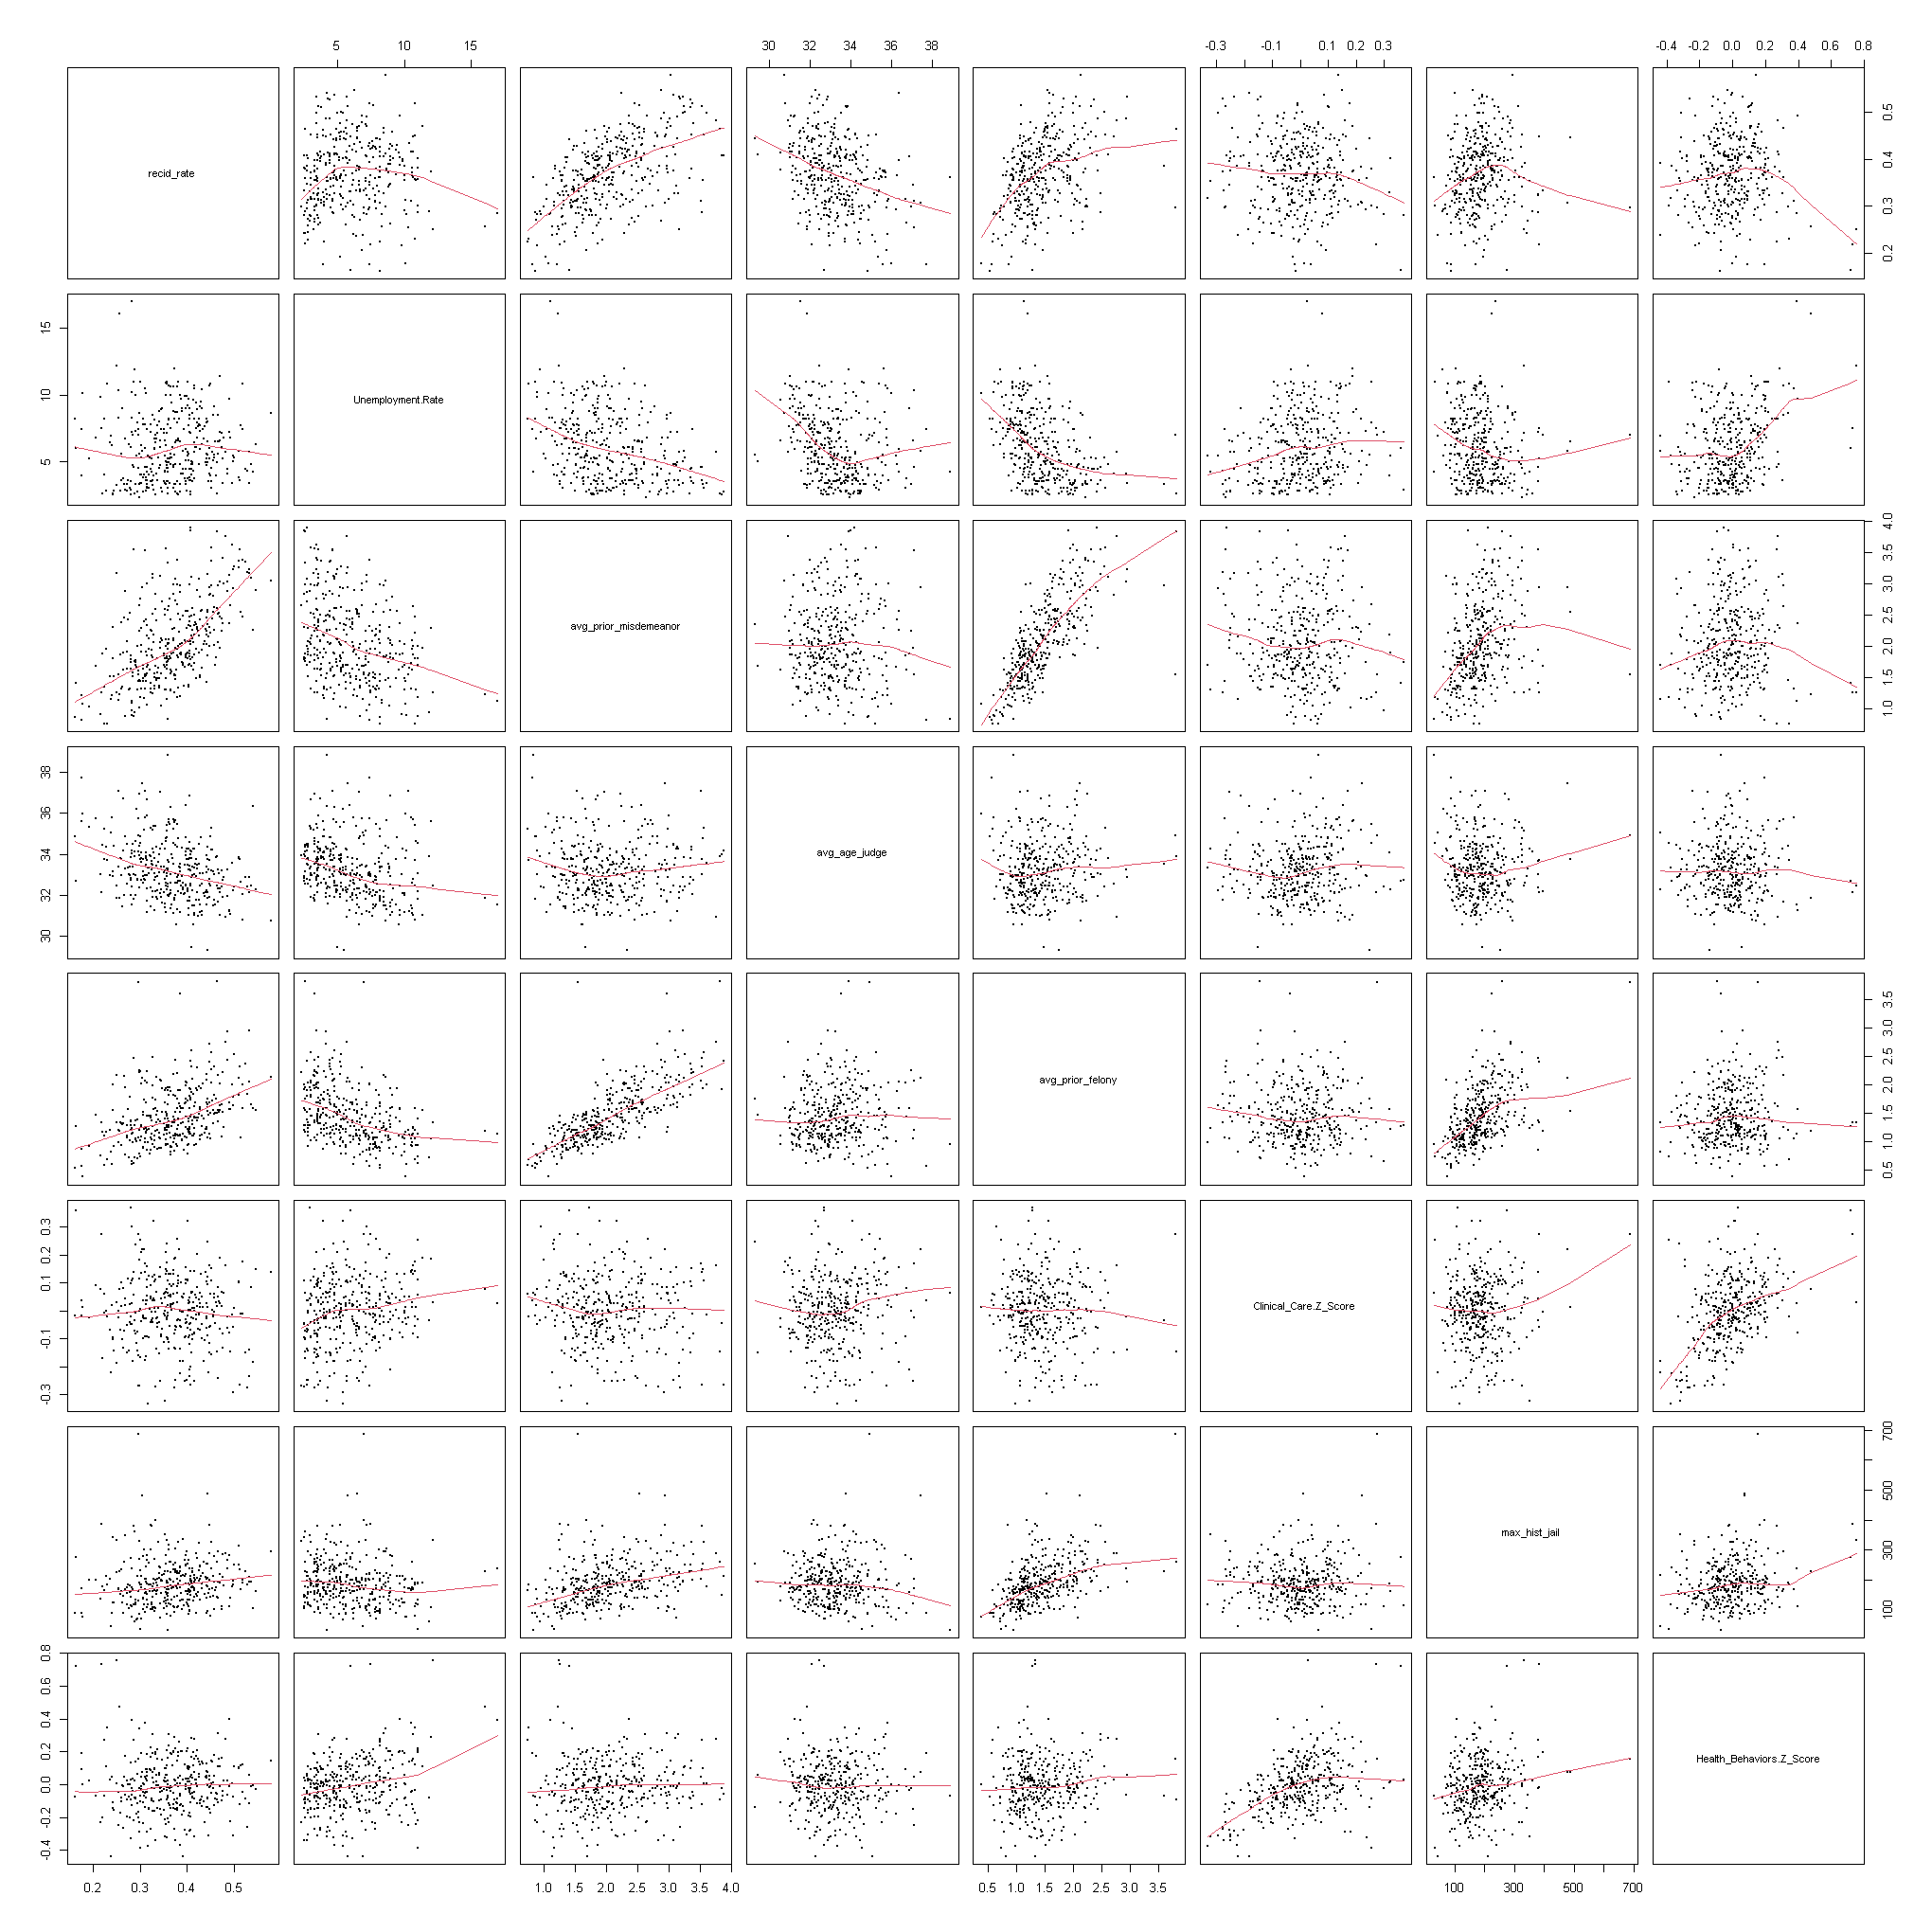

In [14]:
# Variables of interest (based from the selected variables from stepwise regression later in the analysis)
vars <- c("recid_rate", "Unemployment.Rate", "avg_prior_misdemeanor", "avg_age_judge",
          "avg_prior_felony", "Clinical_Care.Z_Score", "max_hist_jail", "Health_Behaviors.Z_Score")

# Plot
options(repr.plot.width = 17, repr.plot.height = 17)
pairs(df_clean[, vars],
      lower.panel = panel.smooth,
      upper.panel = panel.smooth,
      pch = 20, cex = 0.5)

From the plots in the top row, most variables show a non-linear relationship with `recid_rate`. Also, `avg_prior_misdemeanor` and `avg_prior_felony` have a strong linear relationship.

### Boxplots: response vs county/year variable

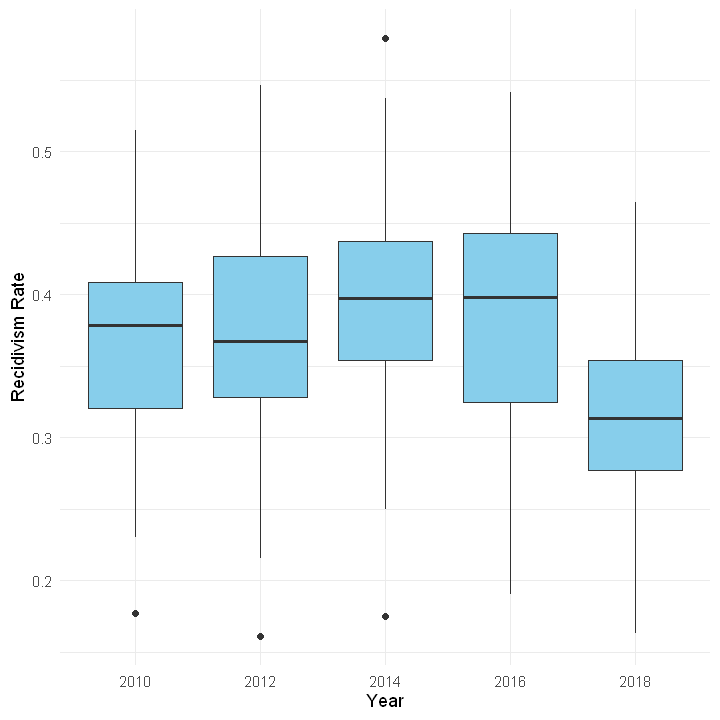

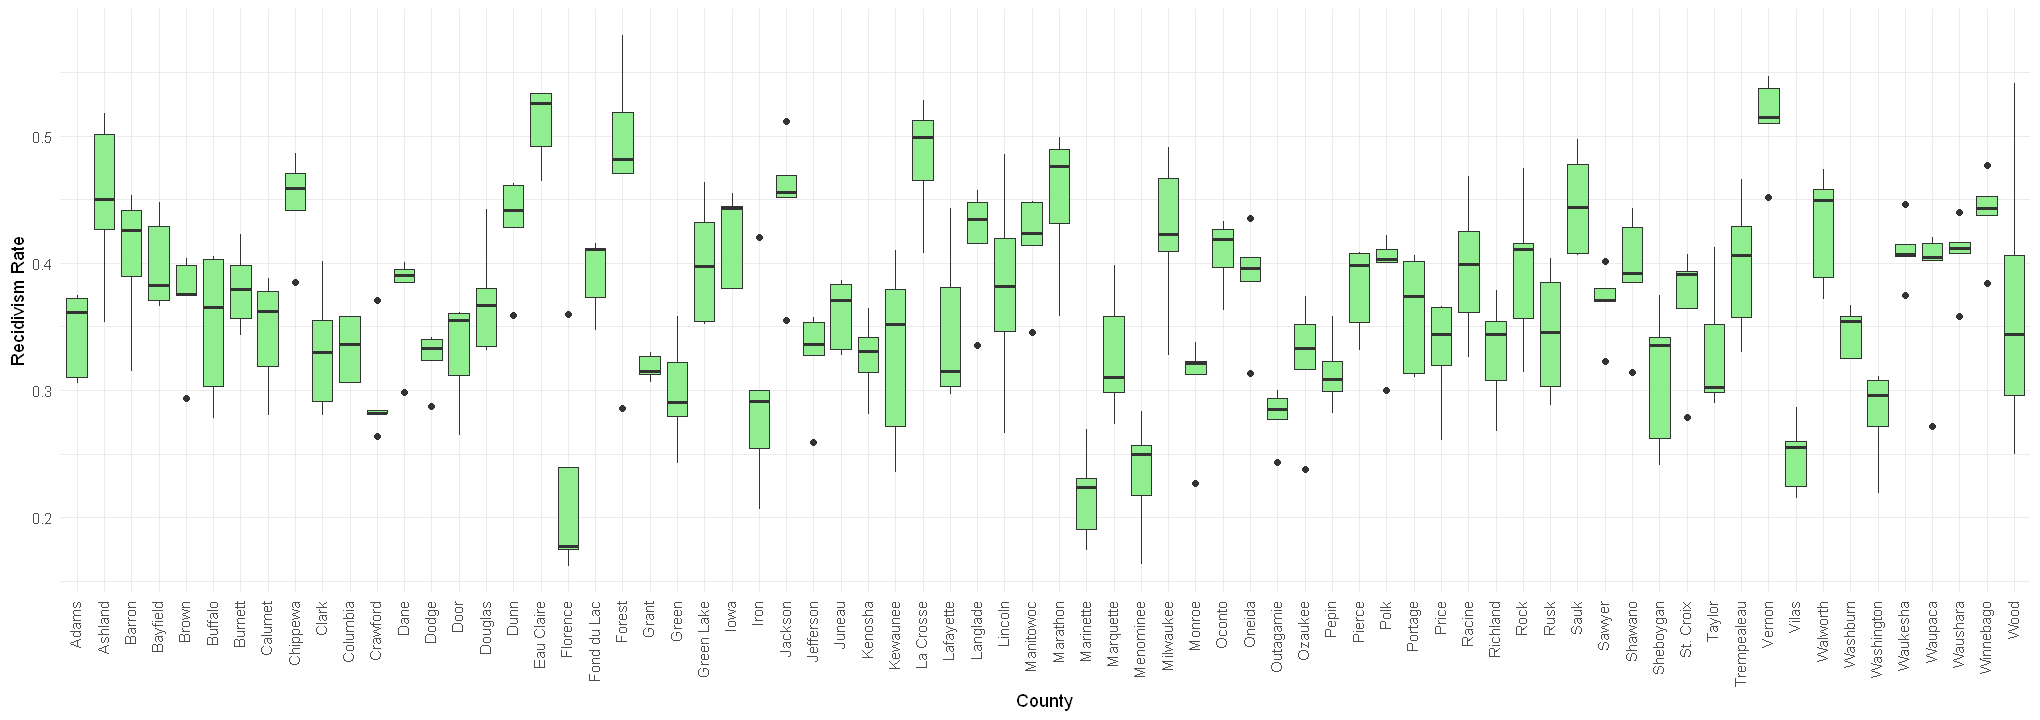

In [15]:
# Redivisism rate vs years
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = year, y = recid_rate)) +
    geom_boxplot(fill = "skyblue") +
    labs(x = "Year", y = "Recidivism Rate") +
    theme_bw(base_size = 14) +
    theme_minimal() 

# Redivisism rate vs county
options(repr.plot.width = 17, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = county_name, y = recid_rate)) +
    geom_boxplot(fill = "lightgreen") +
    labs(x = "County", y = "Recidivism Rate") +
    theme_bw(base_size = 14) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

The boxes are overlapping from the first plot, making it hard to determine if the means are significantly different among groups. Further analysis is required to make a conclusion. However the second plot is likely to have significantly different means among groups.

## F-test for equal means

In [16]:
cat("redivisism rate vs years:")
summary(aov(recid_rate ~ year, data = df_clean))
cat("--------------------------------------------------------------\n")
cat("redivisism rate vs county:")
summary(aov(recid_rate ~ county_name, data = df_clean))

redivisism rate vs years:

             Df Sum Sq Mean Sq F value   Pr(>F)    
year          4 0.2863 0.07158   14.18 9.59e-11 ***
Residuals   355 1.7923 0.00505                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--------------------------------------------------------------
redivisism rate vs county:

             Df Sum Sq Mean Sq F value Pr(>F)    
county_name  71 1.3673 0.01926   7.797 <2e-16 ***
Residuals   288 0.7113 0.00247                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

The p-values from the F-tests with respect to county and year respectively, are both approximately zero. Thus, we reject the null hypothesis of equal means for both.

## Feature Selection: Regularization

In [17]:
# Prepare design matrix
X.cnt <- model.matrix(count_recid ~ . - recid_rate - recid_180d_rate - violent_recid_rate - count_releases, data = df_clean)[,-1]

# Define response variable
y.cnt <- df_clean$count_recid

# Define offset (log of exposure)
offset.cnt <- log(df_clean$count_releases)

In [18]:
# Fit cv poisson model
pois_model.cv <- cv.glmnet(X.cnt, y.cnt, family = "poisson", offset = offset.cnt, alpha = 1, nfolds = 10)

# Fit lasso model with 100 values for lambda
pois_model <- glmnet(X.cnt, y.cnt, family = "poisson", offset = offset.cnt, alpha = 1, nlambda = 100)

# Print best lambda
best_lambda <- pois_model.cv$lambda.min
cat("Best lambda:", best_lambda)

# Extract coefficients at the optimal lambda
coef(pois_model, s = best_lambda)

Best lambda: 0.3999535

104 x 1 sparse Matrix of class "dgCMatrix"
                                               s0
(Intercept)                          9.861685e-02
year2012                            -5.514512e-03
year2014                             3.294030e-02
year2016                             .           
year2018                            -2.071389e-01
pct_black                           -1.030779e-01
pct_hisp                            -1.091643e-01
pct_male                             .           
pct_rural                            .           
pct_urban                            .           
pct_college                          .           
pct_food_stamps                      .           
med_hhinc                            .           
pop_dens                            -1.313595e-05
avg_age_offense                      .           
avg_age_judge                       -3.927333e-02
pct_male_offenders                  -1.129243e-01
pct_probation                        2.184449e-02
avg_pri

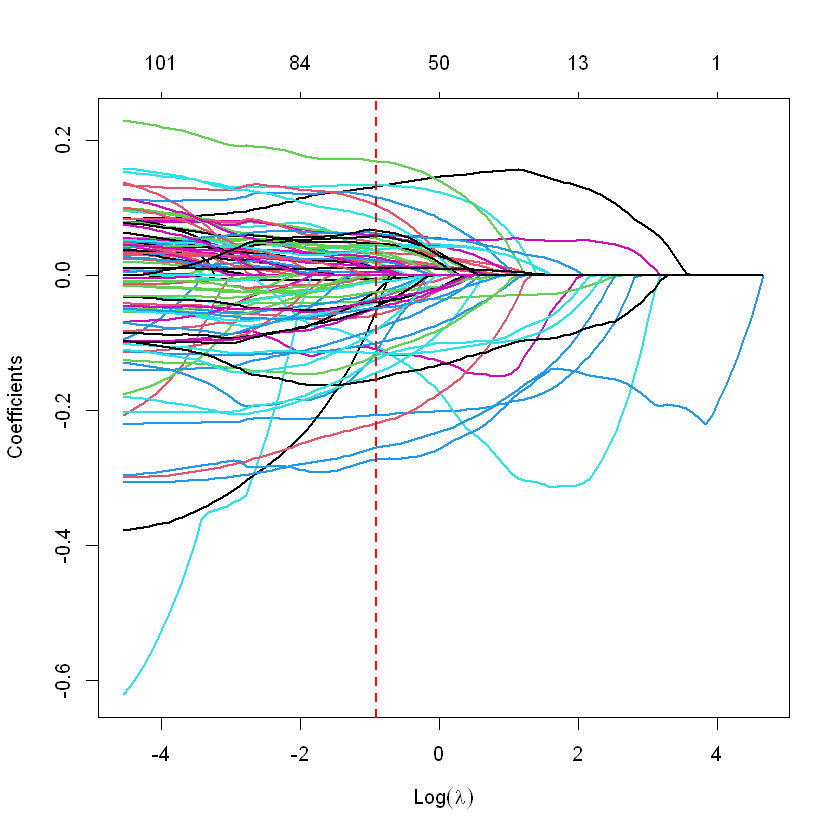

In [19]:
# Plot the lasso coef path
options(repr.plot.width = 7, repr.plot.height = 7)
plot(pois_model, xvar = "lambda", label = FALSE, lwd = 2)
abline(v=log(best_lambda), col='red', lty = 2, lwd = 2)

## Fit poisson model using selected variables 

In [20]:
pois_model_reduced <- glm(count_recid ~ year + county_name + pct_black + pct_hisp + pop_dens + 
                          avg_age_judge + pct_male_offenders + pct_probation + avg_prior_felony +
                          avg_prior_misdemeanor + avg_prior_traffic + avg_highest_severity +
                          max_hist_jail + Unemployment.Rate + Health_Behaviors.Z_Score +
                          Clinical_Care.Z_Score + Physical_Environment.Z_Score,
                          offset = log(count_releases), data = df_clean, family = "poisson") 
summary(pois_model_reduced)


Call:
glm(formula = count_recid ~ year + county_name + pct_black + 
    pct_hisp + pop_dens + avg_age_judge + pct_male_offenders + 
    pct_probation + avg_prior_felony + avg_prior_misdemeanor + 
    avg_prior_traffic + avg_highest_severity + max_hist_jail + 
    Unemployment.Rate + Health_Behaviors.Z_Score + Clinical_Care.Z_Score + 
    Physical_Environment.Z_Score, family = "poisson", data = df_clean, 
    offset = log(count_releases))

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   3.966e-01  3.754e-01   1.057 0.290666    
year2012                      2.649e-03  1.392e-02   0.190 0.849038    
year2014                      5.676e-02  2.429e-02   2.337 0.019441 *  
year2016                      3.076e-02  3.484e-02   0.883 0.377295    
year2018                     -1.748e-01  4.339e-02  -4.028 5.62e-05 ***
county_nameAshland            2.269e-02  6.663e-02   0.341 0.733464    
county_nameBarron             5.188e-0

## Interpretation for statistically significant variables (excluding controlling factors)
`avg_age_judge`: For one unit increase in avg_age_judge, the log expected count of recidivists decreases by 4.130e-02, or the rate ratio for the count of recidivists would be expected to decrease by a factor of exp(4.130e-02)=1.0422, holding everything else fixed.<br>
`avg_prior_felony`: For one unit increase in avg_prior_felony, the log expected count of recidivists increases by 8.044e-02, or the rate ratio for the count of recidivists would be expected to increase by a factor of exp(8.044e-02)=1.0838, holding everything else fixed.<br>
`avg_prior_misdemeanor`: For one unit increase in avg_prior_misdemeanor, the log expected count of recidivists increases by 7.413e-02, or the rate ratio for the count of recidivists would be expected to increase by a factor of exp(7.413e-02)=1.0769, holding everything else fixed.<br>
`Unemployment.Rate`: For one unit increase in Unemployment.Rate, the log expected count of recidivists increases by 1.283e-02, or the rate ratio for the count of recidivists would be expected to increase by a factor of exp(1.283e-02)=1.0129, holding everything else fixed.<br>
`Clinical_Care.Z_Score`: For one unit increase in Clinical_Care.Z_Score, the log expected count of recidivists decreases by 1.852e-01, or the rate ratio for the count of recidivists would be expected to decrease by a factor of exp(1.852e-01)=1.2035, holding everything else fixed.<br>

# Compare full and reduced model

In [21]:
# Fit full model
pois_model_full <- glm(count_recid ~ . - recid_rate - recid_180d_rate - violent_recid_rate - count_releases,
                       offset = log(count_releases), data = df_clean, family = "poisson")

# Compare full vs. reduced model
redstat <- with(pois_model_reduced, cbind(res.deviance = deviance, df = df.residual))
fullstat <- with(pois_model_full, cbind(res.deviance = deviance, df = df.residual))
cat("p-value:", 1 - pchisq((redstat[1]-fullstat[1]), (redstat[2]-fullstat[2])))

p-value: 0.04481465

The p-value is larger than the 0.01 significance level, indicating that we do not reject the null hypothesis that the explanatory power of the reduced model is similar to that of the full model. Thus, we conclude that the reduced model plausibly performs similarly in terms of explanatory power as the full model. We prefer the reduced model because it includes a smaller number of predicting variables.

## Test for overall regression

In [22]:
gstat = pois_model_reduced$null.deviance - deviance(pois_model_reduced)
pvalue = 1-pchisq(gstat, length(coef(pois_model_reduced))-1)
cbind(gstat = gstat, pval = pvalue) 

gstat,pval
5082.009,0


The p-value is zero, so we can reject the null hypothesis that all slope coefficients are equal to zero. Thus, the overall regression appears to have explanatory power.

## GOF test

In [23]:
cat("Using deviance residuals:")
with(pois_model_reduced, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_reduced, cbind(res.deviance = sum(resid(pois_model_reduced, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_reduced, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
335.0462,269,0.003779252


Using pearson residuals:

res.deviance,df,pval
335.1006,269,0.003756468


The p-value is approximately zero for both tests, therefore we reject the null hypothesis of good fit.

## Residual Analysis

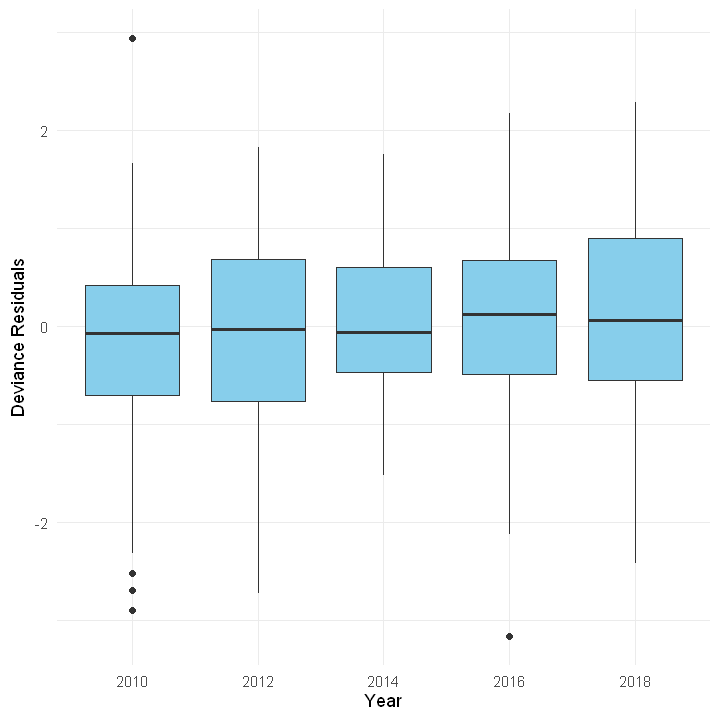

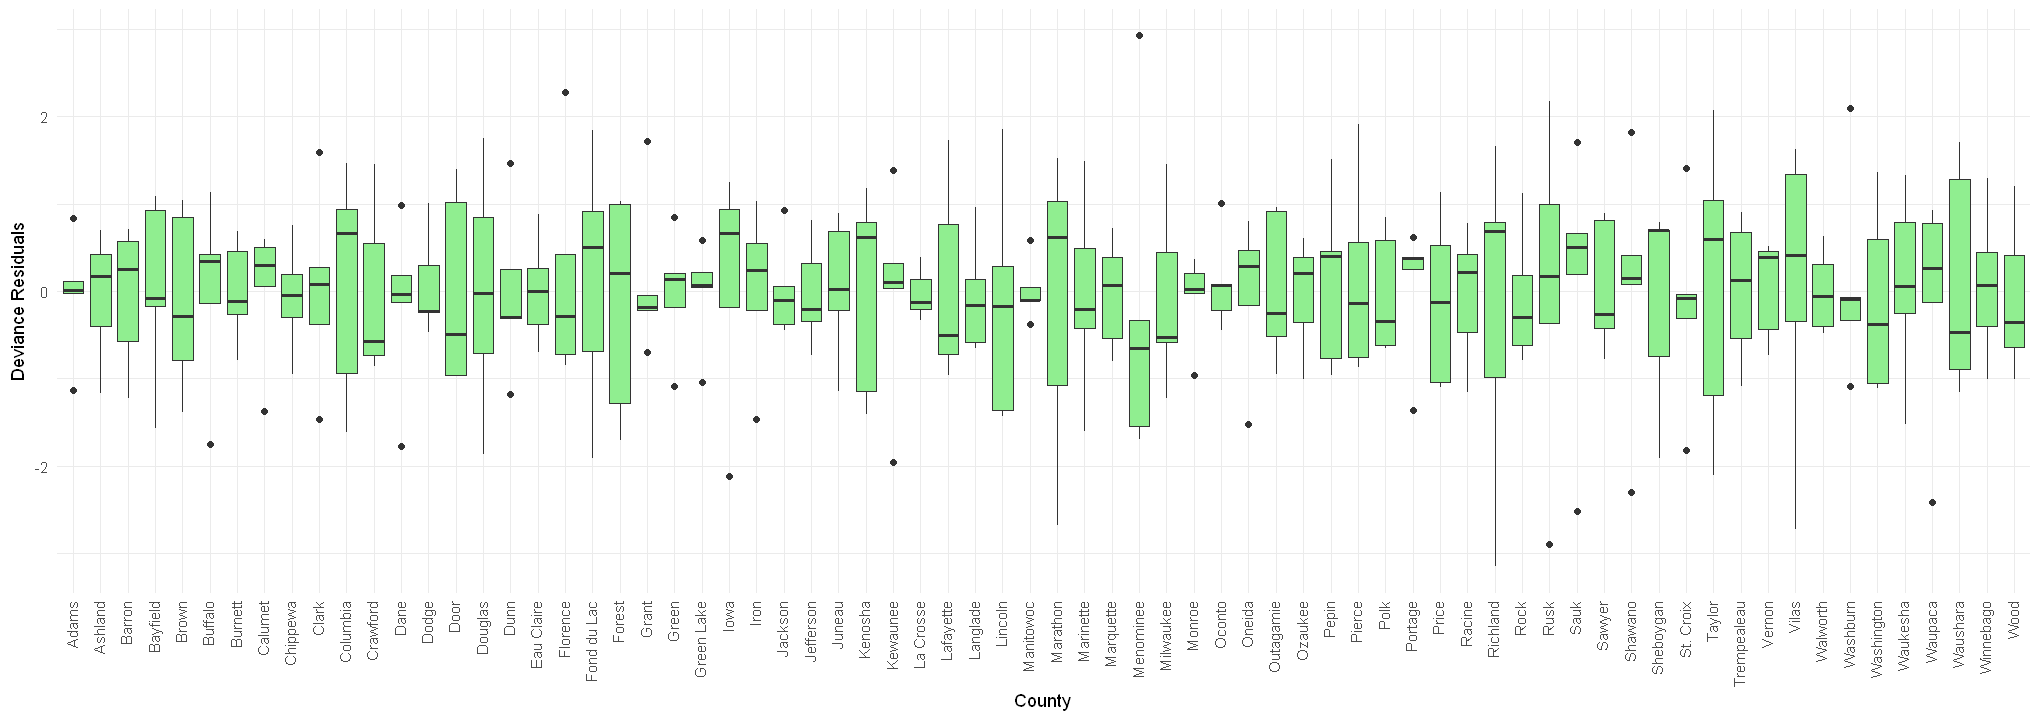

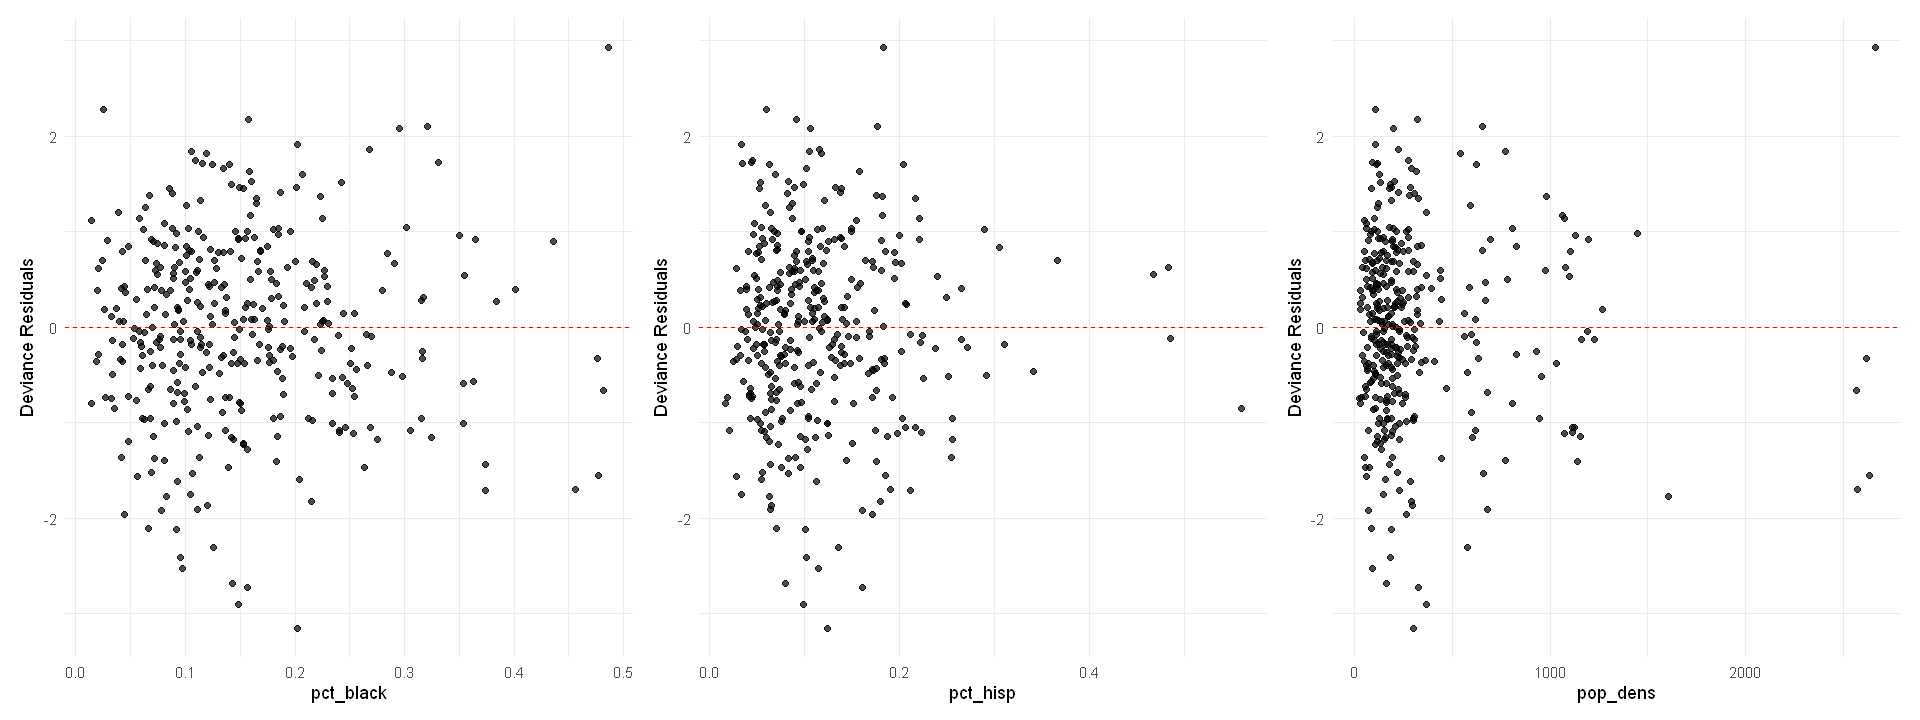

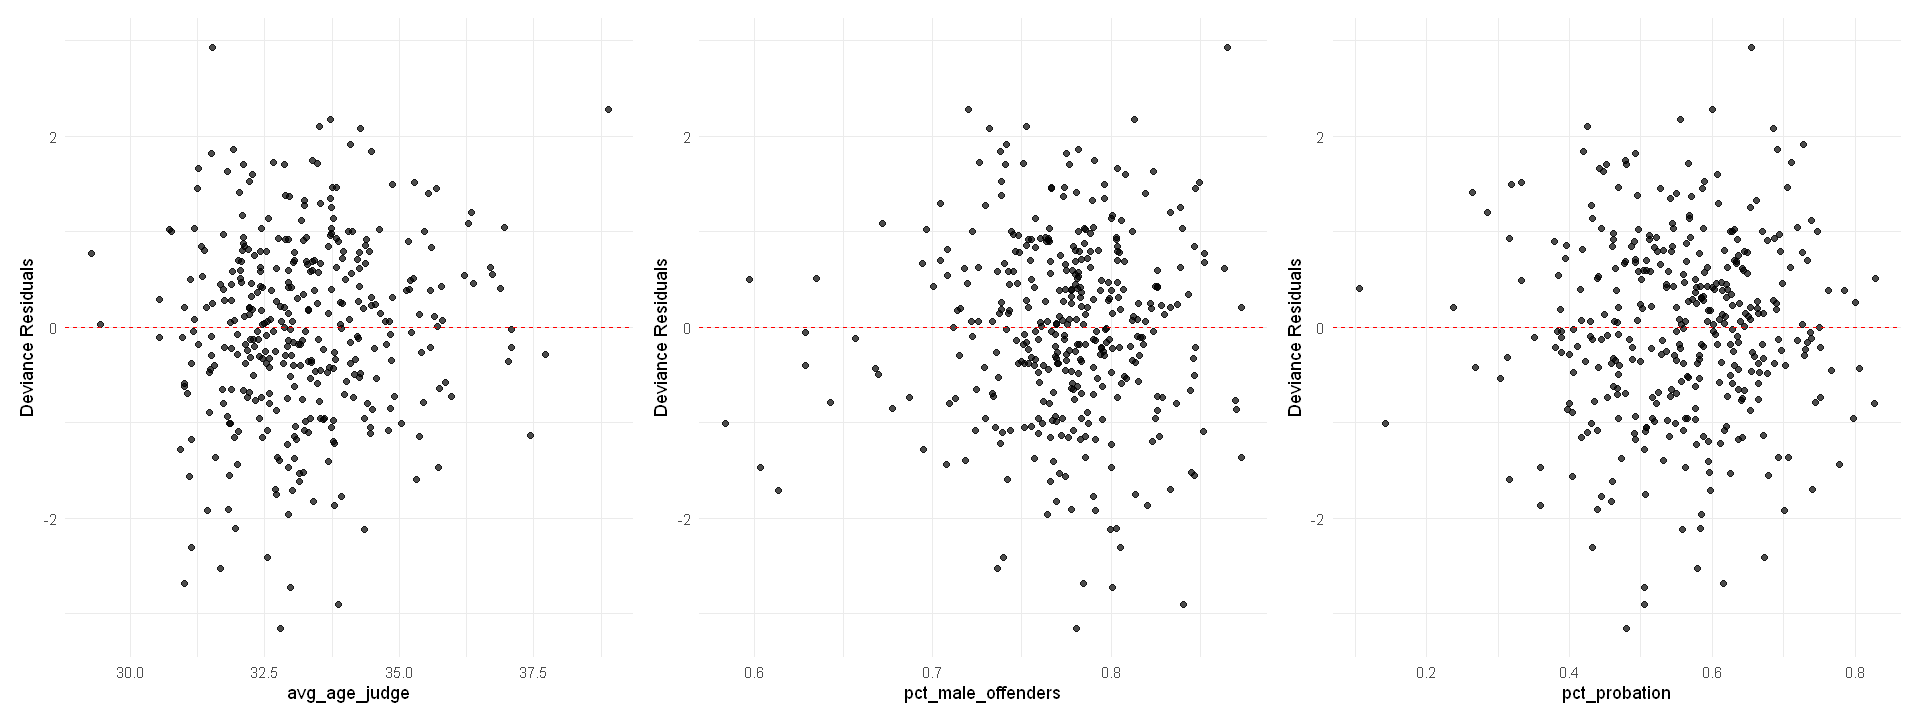

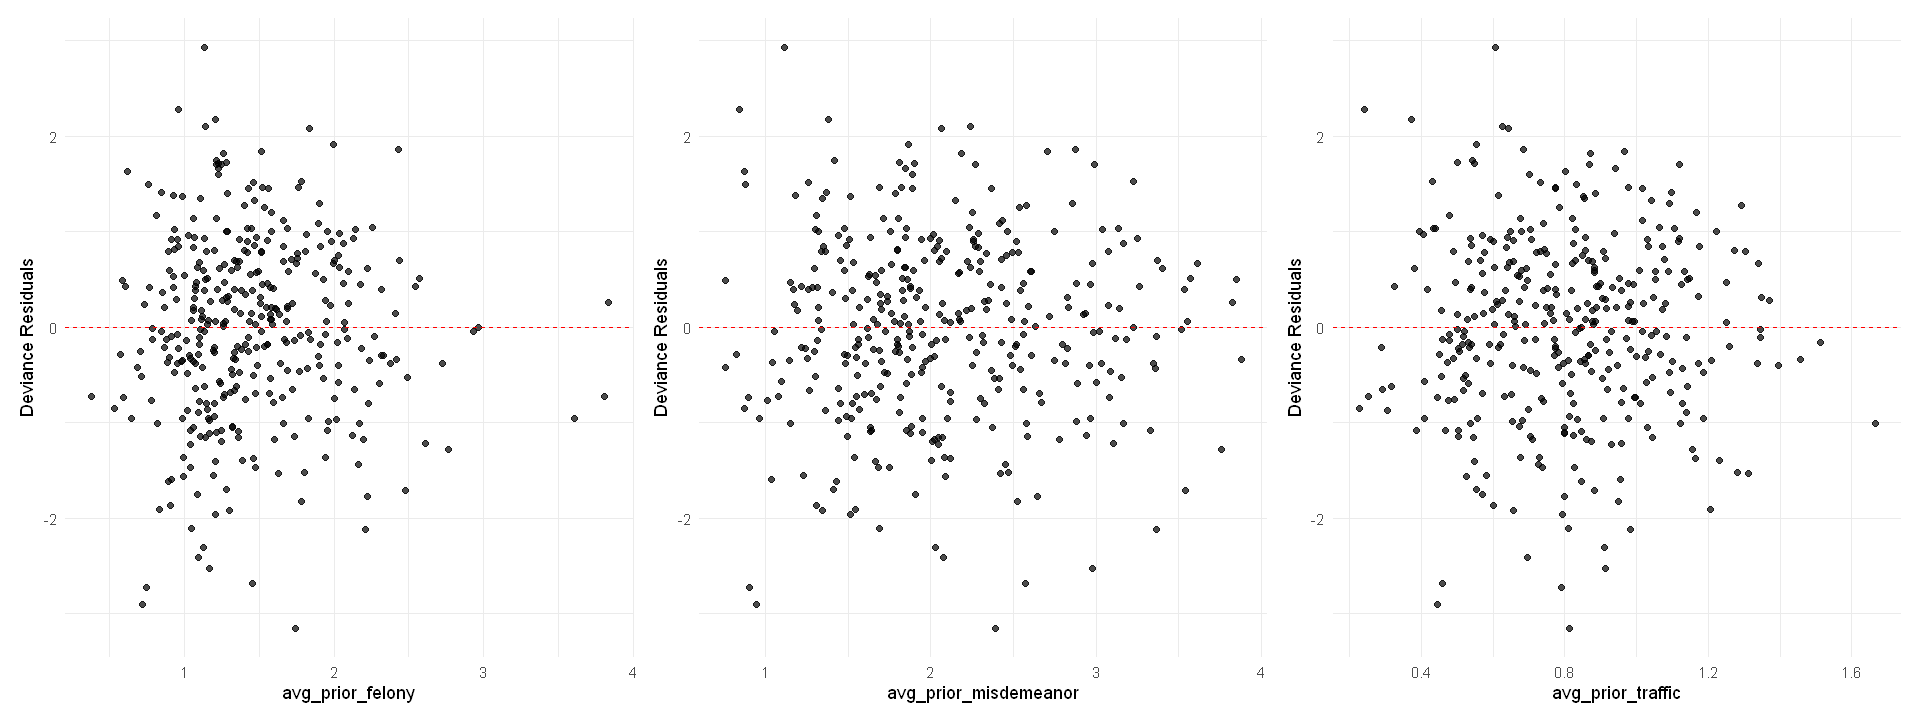

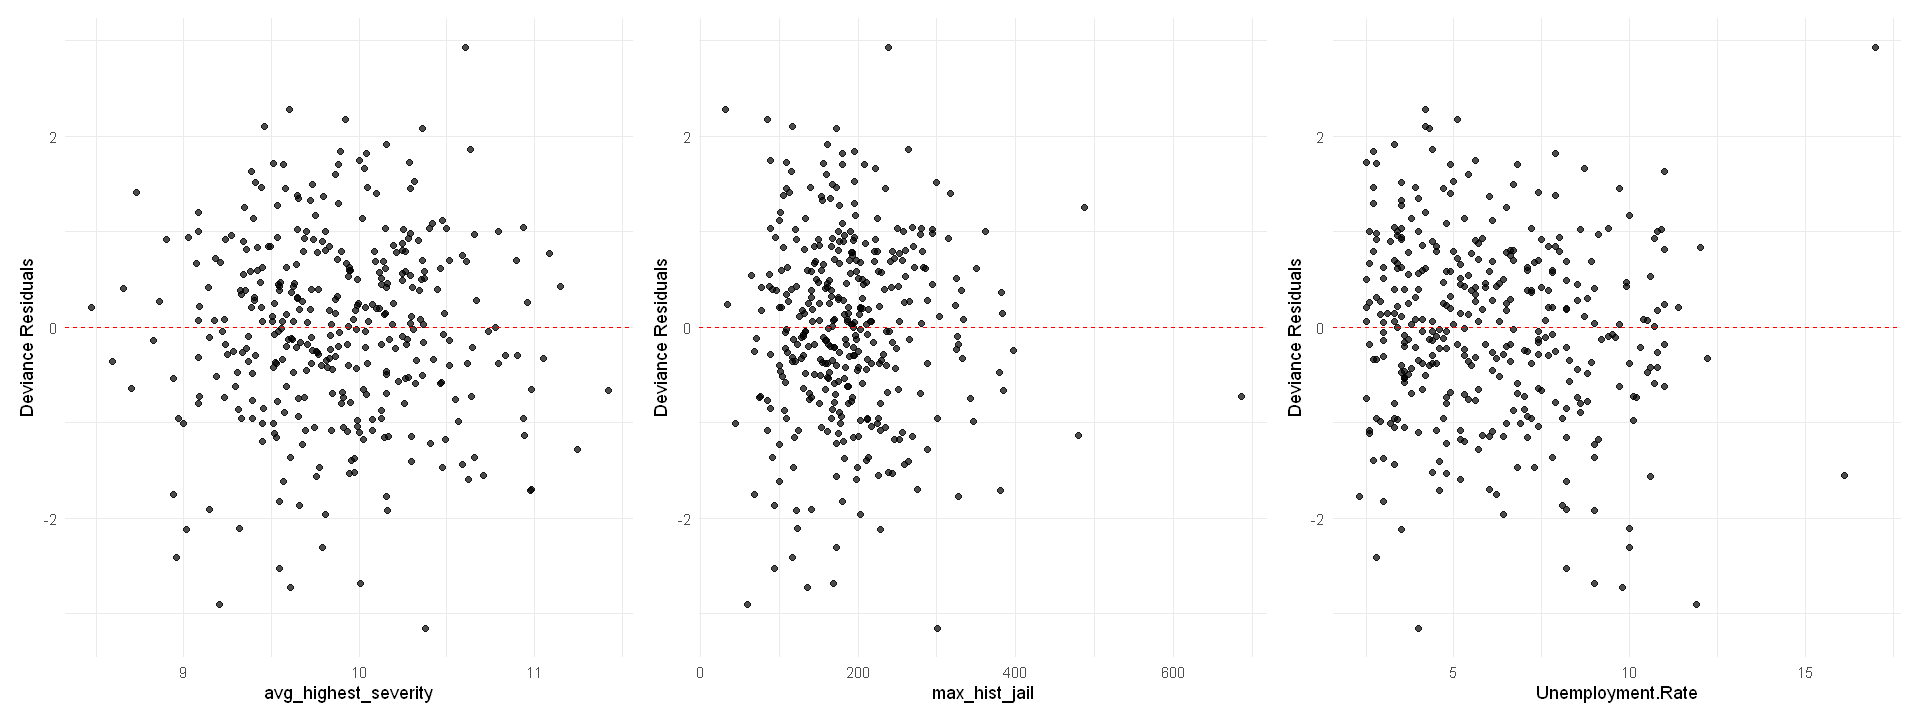

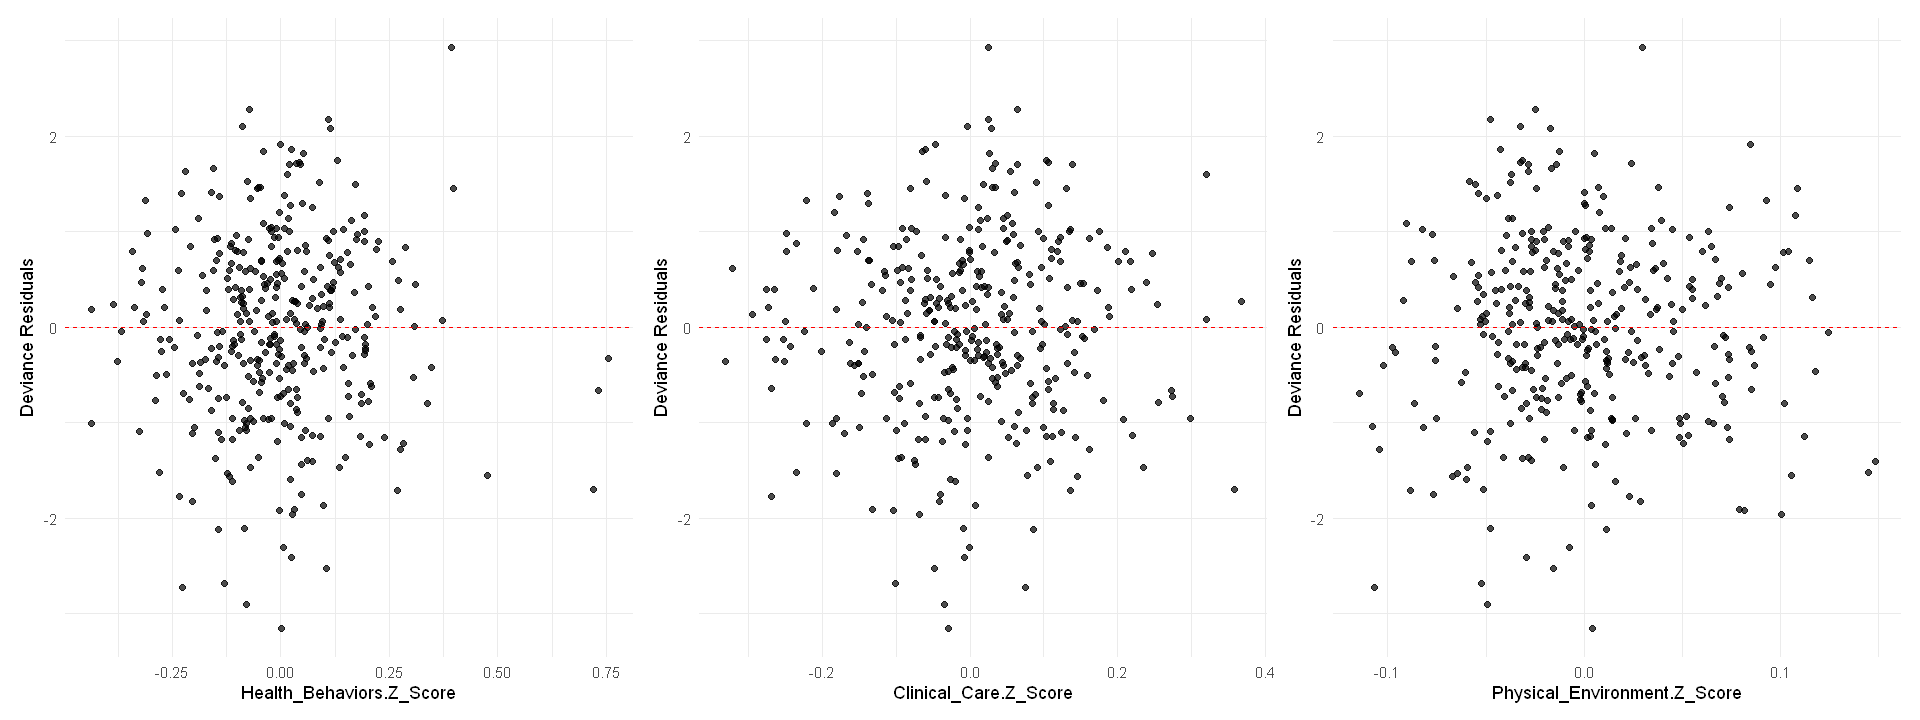

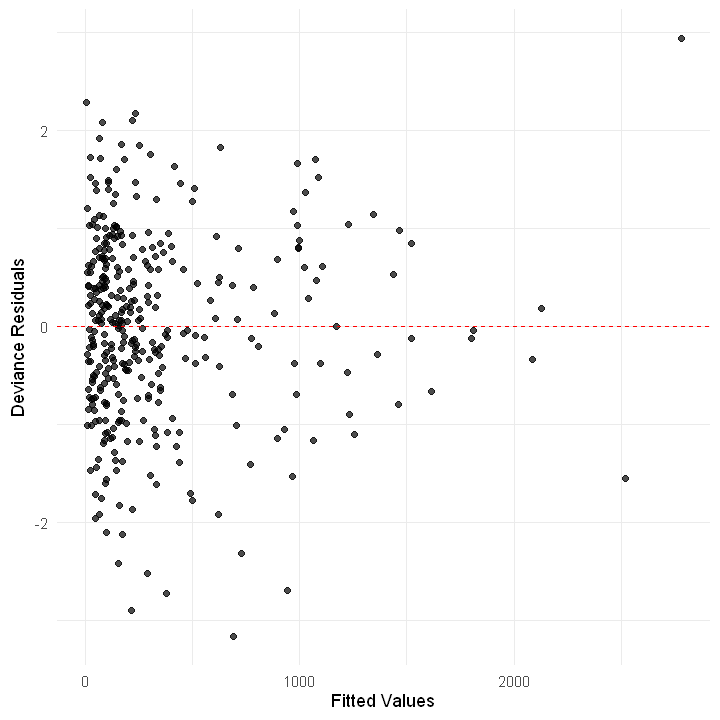

[1] 264 196

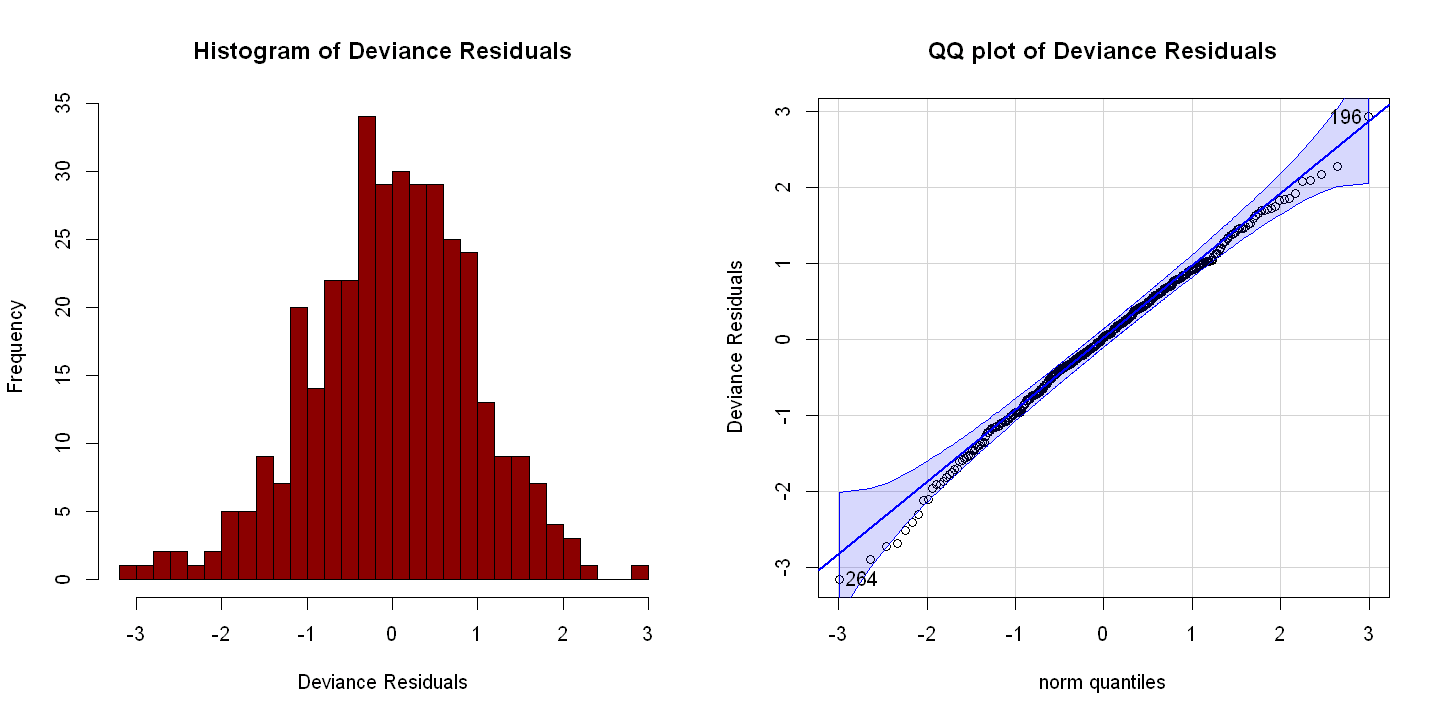

In [24]:
# Get residuals
res <- resid(pois_model_reduced, type = "deviance")

# Categorical variables
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = year, y = res)) +
    geom_boxplot(fill = "skyblue") +
    labs(x = "Year", y = "Deviance Residuals") +
    theme_minimal()

options(repr.plot.width = 17, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = county_name, y = res)) +
    geom_boxplot(fill = "lightgreen") +
    labs(x = "County", y = "Deviance Residuals") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

# Continuous predictors in the model
plot_residual_vs <- function(var) {
    ggplot(df_clean, aes(x = !!sym(var), y = res)) +
        geom_point(alpha = 0.7) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        labs(x = var, y = "Deviance Residuals") +
        theme_minimal()
}

# List of continuous predictors
predictors <- c("pct_black", "pct_hisp", "pop_dens", "avg_age_judge", "pct_male_offenders",
                "pct_probation", "avg_prior_felony", "avg_prior_misdemeanor", "avg_prior_traffic",
                "avg_highest_severity", "max_hist_jail", "Unemployment.Rate", "Health_Behaviors.Z_Score",
                "Clinical_Care.Z_Score", "Physical_Environment.Z_Score")

# Generate plots
resid_plots <- map(predictors, plot_residual_vs)
options(repr.plot.width = 16, repr.plot.height = 6)
wrap_plots(resid_plots[1:3], ncol = 3)
wrap_plots(resid_plots[4:6], ncol = 3)
wrap_plots(resid_plots[7:9], ncol = 3)
wrap_plots(resid_plots[10:12], ncol = 3)
wrap_plots(resid_plots[13:15], ncol = 3)

# Constant variance check
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = fitted(pois_model_reduced), y = res)) +
    geom_point(alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Fitted Values", y = "Deviance Residuals") +
    theme_minimal()

# Normality check
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
hist(res, breaks = 30, col = "red4", xlab = "Deviance Residuals", main = "Histogram of Deviance Residuals")
qqPlot(res, envelope = 0.95, ylab = "Deviance Residuals", main = "QQ plot of Deviance Residuals")

The linearity assumption holds since the residuals are scattered randomly around the zero line. Constant variance does not hold because variability is decreasing with the fitted values. Normality assumption does not hold because not all residuals are inside the envelope in the QQ plot.

## Overdispersion

In [25]:
cat("Using deviance residuals, overdispersion parameter:",
    pois_model_reduced$deviance/pois_model_reduced$df.residual, "\n")
cat("Using pearson residuals, overdispersion parameter:", 
    sum(residuals(pois_model_reduced, type = "pearson")^2) /pois_model_reduced$df.residual)

Using deviance residuals, overdispersion parameter: 1.245525 
Using pearson residuals, overdispersion parameter: 1.245727

Using a threshold of 2, the reduced model is not overdispered. However, let's still try another model, such as quasipoisson, to handle the slight overdispersion.

In [26]:
pois_model_qp <- glm(count_recid ~ year + county_name + pct_black + pct_hisp + pop_dens + 
                          avg_age_judge + pct_male_offenders + pct_probation + avg_prior_felony +
                          avg_prior_misdemeanor + avg_prior_traffic + avg_highest_severity +
                          max_hist_jail + Unemployment.Rate + Health_Behaviors.Z_Score +
                          Clinical_Care.Z_Score + Physical_Environment.Z_Score,
                          offset = log(count_releases), data = df_clean, family = "quasipoisson")

Let's check if this model improves GOF.

In [27]:
cat("Using deviance residuals:")
with(pois_model_qp, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_qp, cbind(res.deviance = sum(resid(pois_model_qp, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_qp, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
335.0462,269,0.003779252


Using pearson residuals:

res.deviance,df,pval
335.1006,269,0.003756468


The quasipoisson model does not improve the fit. Let's try negative binomial instead and check GOF.

In [28]:
nb_model <- glm.nb(count_recid ~ year + county_name + pct_black + pct_hisp + pop_dens + 
                          avg_age_judge + pct_male_offenders + pct_probation + avg_prior_felony +
                          avg_prior_misdemeanor + avg_prior_traffic + avg_highest_severity +
                          max_hist_jail + Unemployment.Rate + Health_Behaviors.Z_Score +
                          Clinical_Care.Z_Score + Physical_Environment.Z_Score +
                          count_releases, data = df_clean)

# GOF
cat("Using deviance residuals:")
with(nb_model, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(nb_model, cbind(res.deviance = sum(resid(nb_model, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(nb_model, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
406.5695,268,9.345692e-08


Using pearson residuals:

res.deviance,df,pval
397.8981,268,4.219445e-07


The p-value is even smaller now and thus we reject the null hypothesis of good fit.

## Outliers

In [29]:
# Evaluate deviance residuals vs the normal quantile with prob = 0.99995.
dev_residuals <- residuals(pois_model_reduced, type = "deviance")
outliers <- which(abs(dev_residuals) > qnorm(0.99995))
cat("Number of outliers:", length(outliers))

Number of outliers: 0

Assuming goodness of fit (deviance coming from a N(0,1)) and comparing residuals vs the quantile of the 0.99995 tail means that the probability of a residual to be larger than this quantile is 0.00001, which is a very small probability. This rule identified zero observations to be outliers. However, goodness of fit was rejected meaning this rule is likely to be invalid.

## Multicollinearity

In [30]:
vif_vals <- vif(pois_model_reduced)
vif_vals

# Compute threshold
vif_threshold = max(10, (1-summary(pois_model_reduced)$r.squared))
cat("VIF threshold:", vif_threshold, "\n")

# Get variables with VIF > threshold
cat("Multicollinear variables:\n")
print(rownames(vif_vals)[vif_vals[, "GVIF"] > vif_threshold])

,GVIF,Df,GVIF^(1/(2*Df))
year,4.181327e+01,4,1.594646
county_name,5.857726e+10,71,1.190773
pct_black,1.225538e+01,1,3.500768
pct_hisp,4.987431e+00,1,2.233256
pop_dens,3.486476e+02,1,18.672107
avg_age_judge,5.706612e+00,1,2.388852
pct_male_offenders,5.255488e+00,1,2.292485
pct_probation,9.948668e+00,1,3.154151
avg_prior_felony,1.807234e+01,1,4.251158
avg_prior_misdemeanor,3.114952e+01,1,5.581175


VIF threshold: 10 
Multicollinear variables:
[1] "year"                  "county_name"           "pct_black"            
[4] "pop_dens"              "avg_prior_felony"      "avg_prior_misdemeanor"
[7] "avg_prior_traffic"     "avg_highest_severity"  "Unemployment.Rate"    


Even after conducting feature selection, we still have multicollinear variables where most values are greater than the threshold of 10. This means that these predictors are highly correlated with each other, which can inflate standard errors and lead to unreliable coefficient estimates.

## Resolving multicollinearity

Let's try another variable selection approach – stepwise regression.

In [31]:
min_model <- glm(count_recid ~ 1, offset = log(count_releases), data = df_clean, family = 'poisson')
step_model <- step(min_model,
                   scope = list(lower = min_model, upper = pois_model_reduced), 
                   direction = "both", 
                   trace = FALSE)
summary(step_model)


Call:
glm(formula = count_recid ~ county_name + year + Unemployment.Rate + 
    avg_prior_misdemeanor + avg_age_judge + avg_prior_felony + 
    Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score, 
    family = "poisson", data = df_clean, offset = log(count_releases))

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.0832152  0.2511933   0.331 0.740433    
county_nameAshland        0.0174317  0.0649137   0.269 0.788287    
county_nameBarron         0.0684146  0.0580096   1.179 0.238252    
county_nameBayfield       0.0357133  0.0681706   0.524 0.600362    
county_nameBrown          0.0009723  0.0634868   0.015 0.987781    
county_nameBuffalo       -0.0125623  0.0821423  -0.153 0.878451    
county_nameBurnett        0.0353458  0.0679350   0.520 0.602863    
county_nameCalumet       -0.1025598  0.0741574  -1.383 0.166664    
county_nameChippewa       0.0448836  0.0651506   0.689 0.490873    
county_nameClark      

This approach selected less variables. Let's fit a new poisson model using these variables.

In [32]:
pois_model_reduced2 <- glm(count_recid ~ county_name + year + Unemployment.Rate + 
                           avg_prior_misdemeanor + avg_age_judge + avg_prior_felony + 
                           Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score, 
                          family = "poisson", data = df_clean, offset = log(count_releases)) 

Let's check whether this model is better than the original reduced model.

In [33]:
# Compare reduced model1 vs. reduced model2
red2 <- with(pois_model_reduced2, cbind(res.deviance = deviance, df = df.residual))
red1 <- with(pois_model_reduced, cbind(res.deviance = deviance, df = df.residual))
cat("p-value:", 1 - pchisq((red2[1]-red1[1]), (red2[2]-red1[2])))

p-value: 0.6501943

The p-value is high therefore we select the new reduced model. Now, let's check for multicollinearity.

In [34]:
vif_vals2 <- vif(pois_model_reduced2)
vif_vals2

# Compute threshold
vif_threshold2 = max(10, (1-summary(pois_model_reduced2)$r.squared))
cat("VIF threshold:", vif_threshold2, "\n")

# Get variables with VIF > threshold
cat("Multicollinear variables:\n")
print(rownames(vif_vals2)[vif_vals2[, "GVIF"] > vif_threshold2])

,GVIF,Df,GVIF^(1/(2*Df))
county_name,94067.130993,71,1.083987
year,24.025878,4,1.487938
Unemployment.Rate,28.553438,1,5.343542
avg_prior_misdemeanor,28.173368,1,5.307859
avg_age_judge,5.558985,1,2.357750
avg_prior_felony,12.593814,1,3.548776
Clinical_Care.Z_Score,8.850306,1,2.974946
max_hist_jail,4.105127,1,2.026111
Health_Behaviors.Z_Score,9.478273,1,3.078680


VIF threshold: 10 
Multicollinear variables:
[1] "county_name"           "year"                  "Unemployment.Rate"    
[4] "avg_prior_misdemeanor" "avg_prior_felony"     


We still have multicollinearity but with less variables.

##  Resolving GOF

 Even though the model has multicollinearity, let's still check whether GOF has improved using the reduced model from stepwise regression.

In [35]:
cat("Using deviance residuals:")
with(pois_model_reduced2, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_reduced2, cbind(res.deviance = sum(resid(pois_model_reduced2, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_reduced2, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
341.0197,277,0.005194612


Using pearson residuals:

res.deviance,df,pval
340.9164,277,0.00525213


This feature selection approach did not improve goodness of fit. This time, Let's transform `Unemployment.Rate` to factor since it has a non-linear relationship with `recid_rate` as shown in the pairs panel.

In [36]:
# factorize
df_clean <- df_clean %>% mutate(Unemployment.Rate_bin = cut(Unemployment.Rate, breaks = 3))

# fit
pois_model_reduced3 <- glm(count_recid ~ county_name + year + Unemployment.Rate_bin + 
                           avg_prior_misdemeanor + avg_age_judge + avg_prior_felony + 
                           Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score, 
                          family = "poisson", data = df_clean, offset = log(count_releases)) 

Let's check GOF:

In [37]:
cat("Using deviance residuals:")
with(pois_model_reduced3, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_reduced3, cbind(res.deviance = sum(resid(pois_model_reduced3, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_reduced3, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
330.9558,276,0.0129528


Using pearson residuals:

res.deviance,df,pval
331.1976,276,0.01265147


Now, the p-value is larger than a significance level of 0.01. Therefore, we fail to reject the null hypothesis meaning the model has a good fit. Let's do residual analysis using this model.

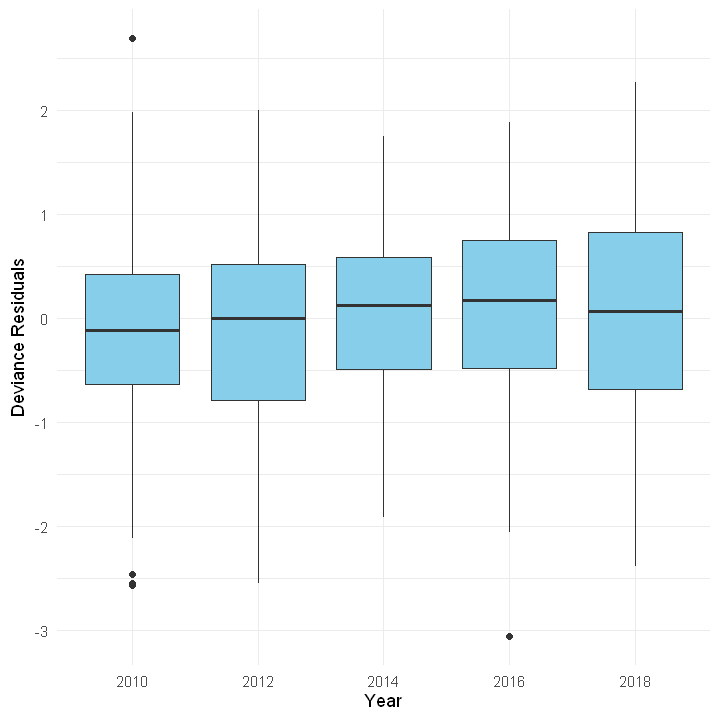

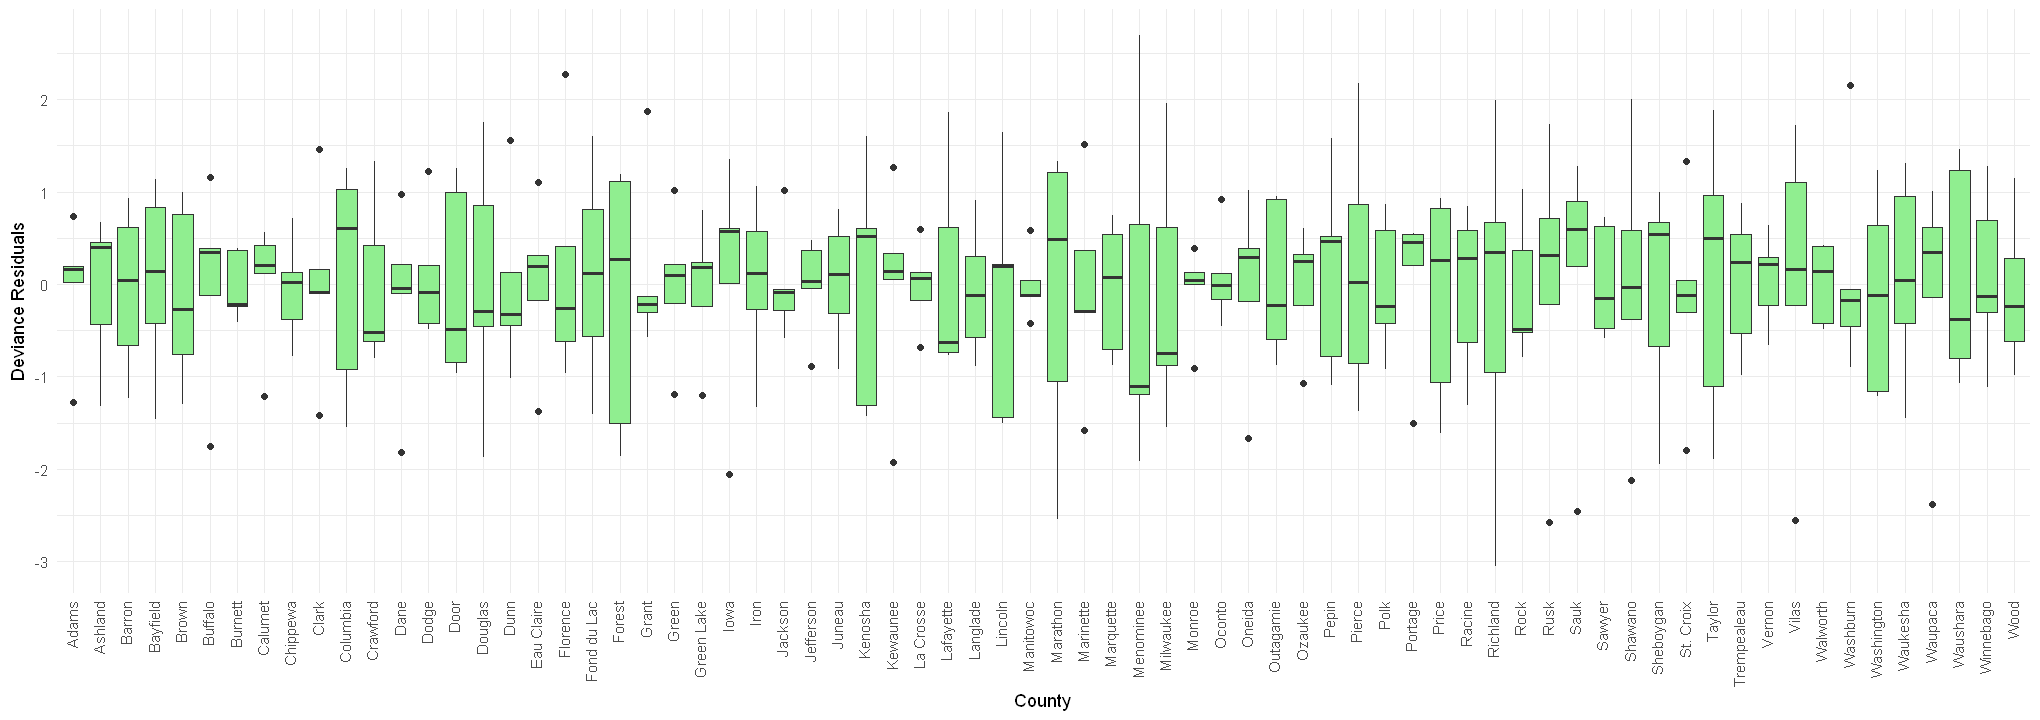

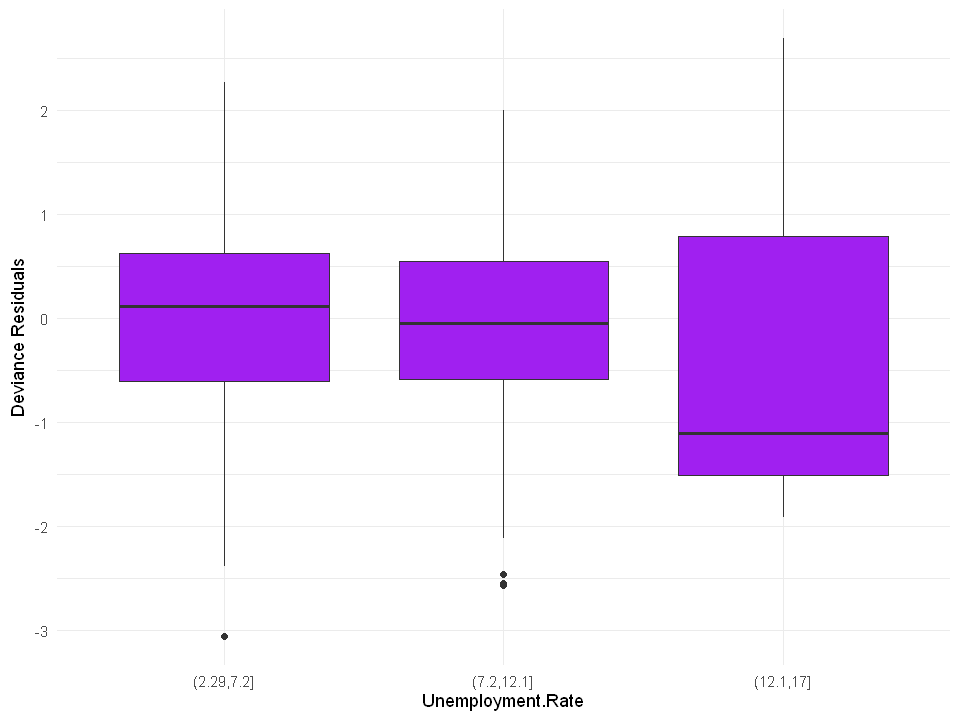

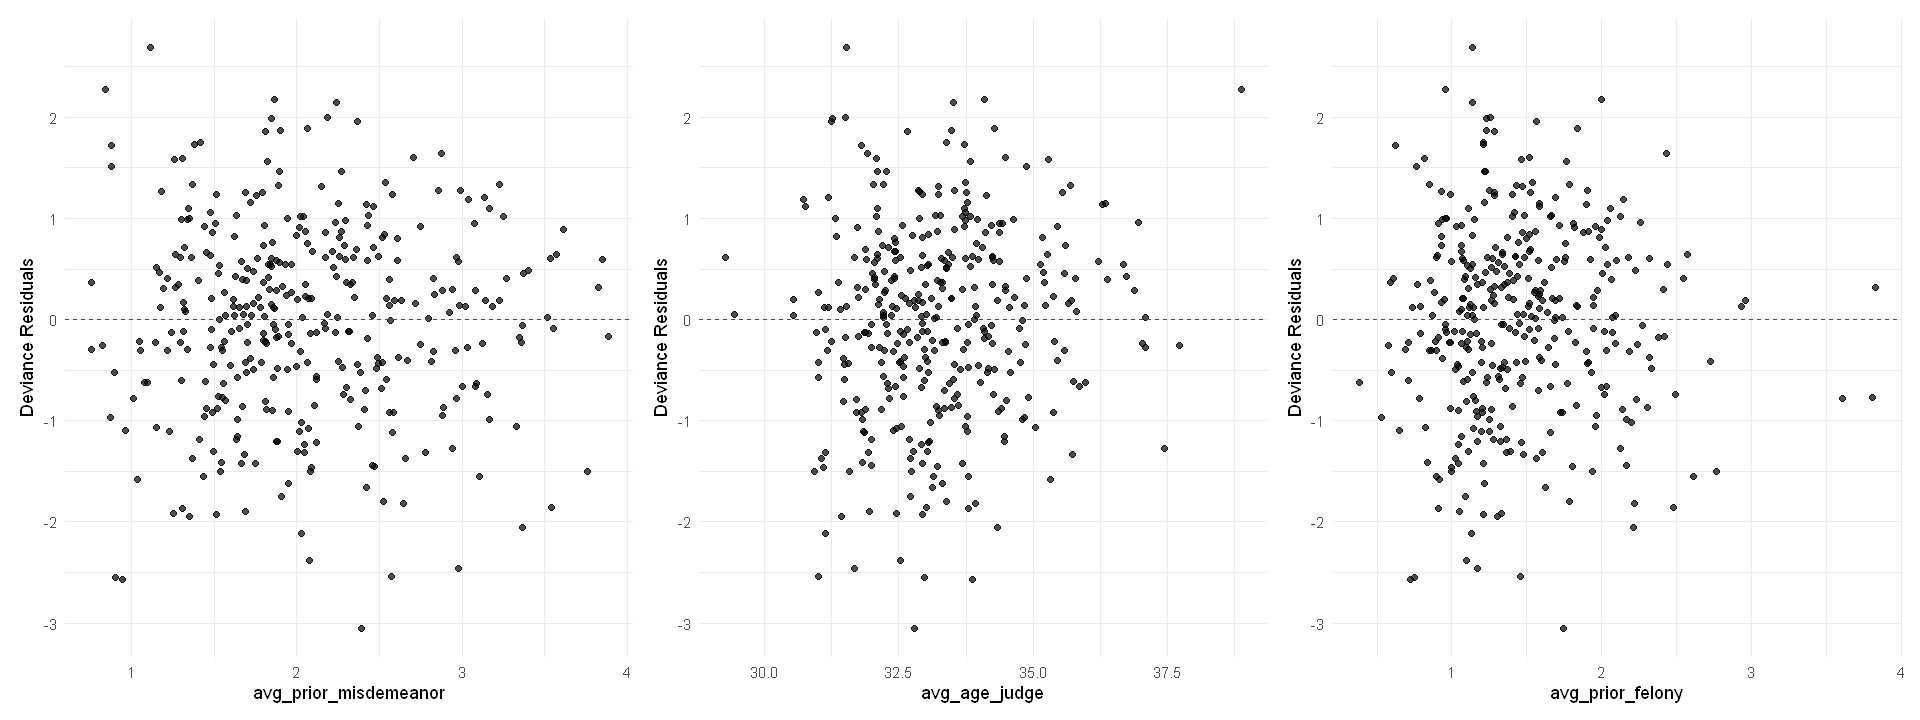

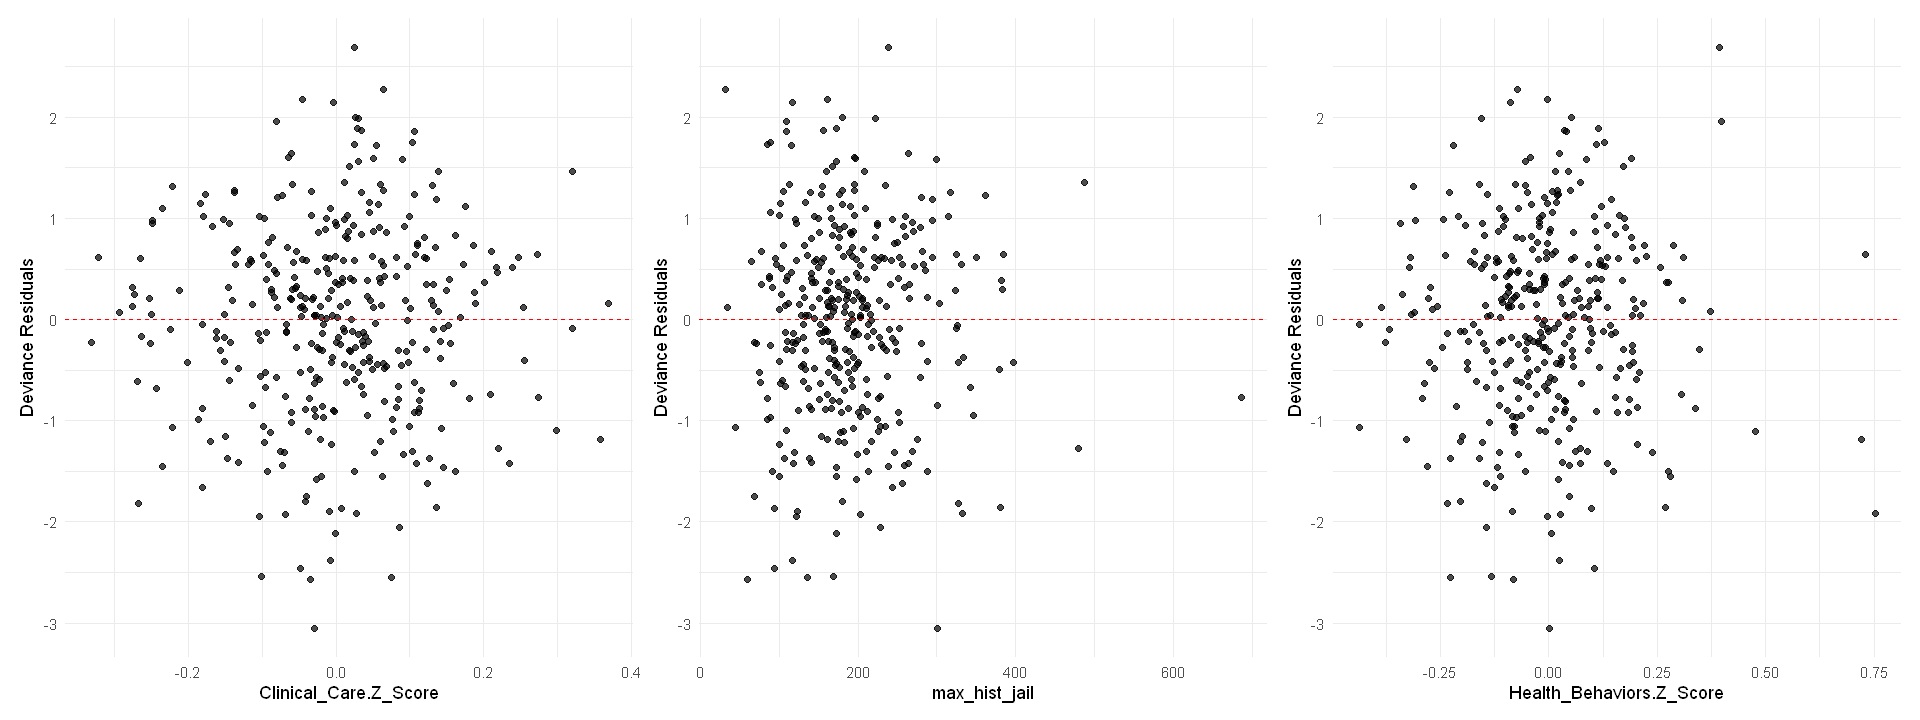

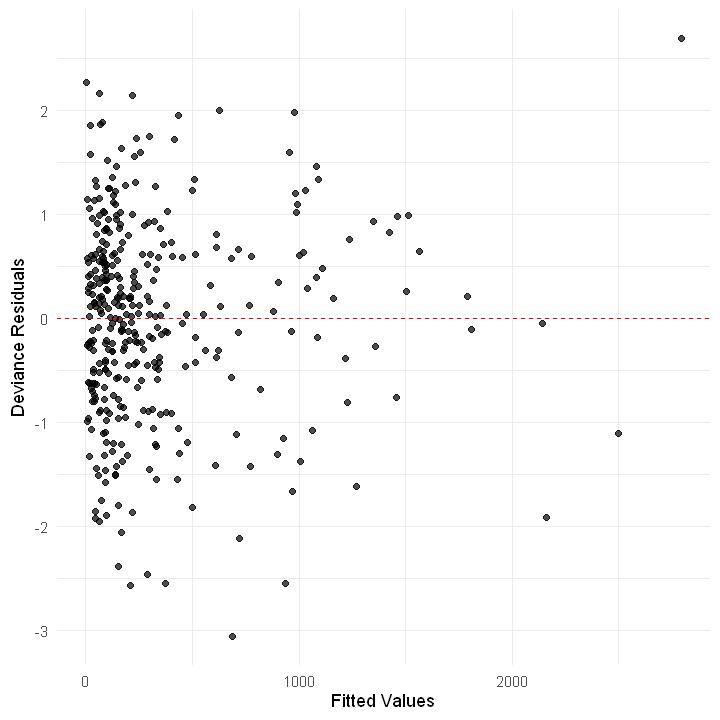

[1] 264 196

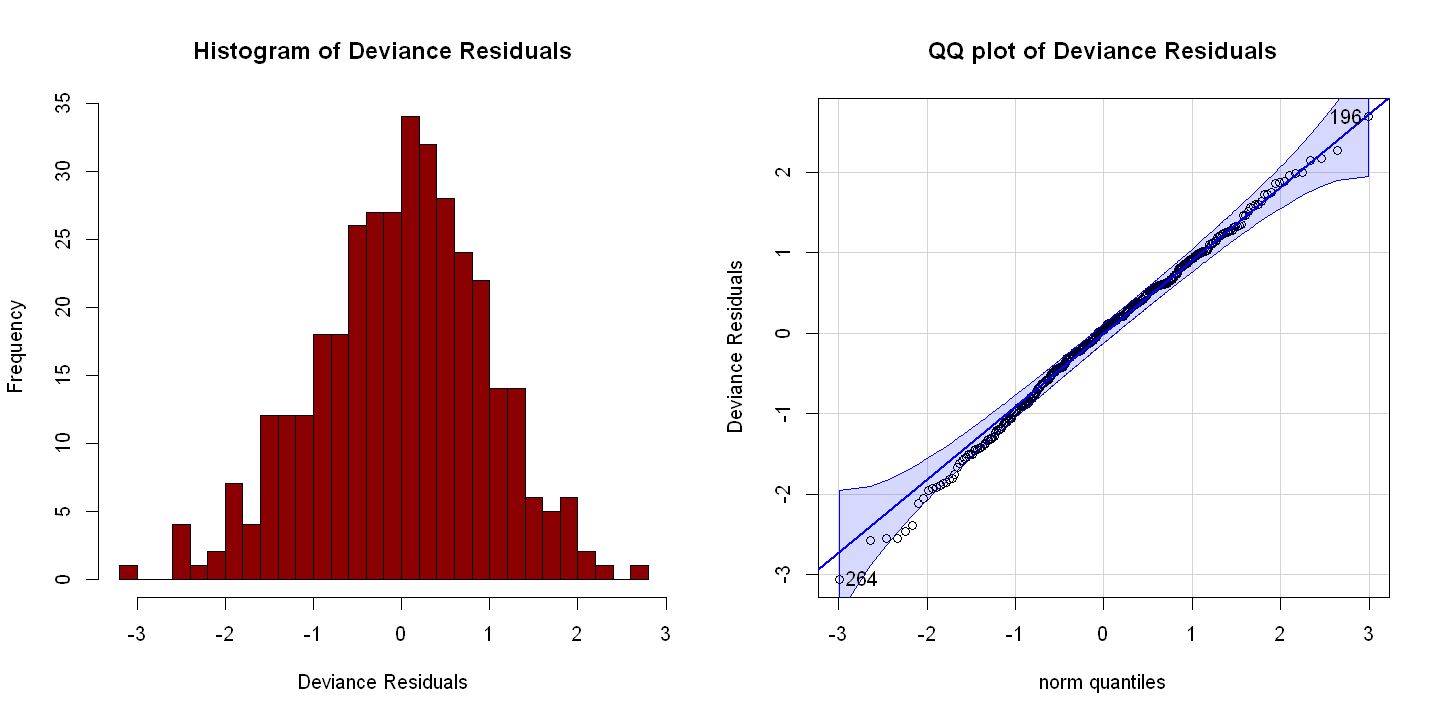

In [38]:
# Get residuals
res <- resid(pois_model_reduced3, type = "deviance")

# Categorical variables
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = year, y = res)) +
    geom_boxplot(fill = "skyblue") +
    labs(x = "Year", y = "Deviance Residuals") +
    theme_minimal()

options(repr.plot.width = 17, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = county_name, y = res)) +
    geom_boxplot(fill = "lightgreen") +
    labs(x = "County", y = "Deviance Residuals") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = Unemployment.Rate_bin, y = res)) +
    geom_boxplot(fill = "purple") +
    labs(x = "Unemployment.Rate", y = "Deviance Residuals") +
    theme_minimal()

# Continuous predictors in the model
plot_residual_vs <- function(var) {
    ggplot(df_clean, aes(x = !!sym(var), y = res)) +
        geom_point(alpha = 0.7) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        labs(x = var, y = "Deviance Residuals") +
        theme_minimal()
}

# List of continuous predictors
predictors <- c("avg_prior_misdemeanor", "avg_age_judge", "avg_prior_felony",
                "Clinical_Care.Z_Score", "max_hist_jail", "Health_Behaviors.Z_Score")

# Generate plots
resid_plots <- map(predictors, plot_residual_vs)
options(repr.plot.width = 16, repr.plot.height = 6)
wrap_plots(resid_plots[1:3], ncol = 3)
wrap_plots(resid_plots[4:6], ncol = 3)

# Constant variance check
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = fitted(pois_model_reduced3), y = res)) +
    geom_point(alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Fitted Values", y = "Deviance Residuals") +
    theme_minimal()

# Normality check
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
hist(res, breaks = 30, col = "red4", xlab = "Deviance Residuals", main = "Histogram of Deviance Residuals")
qqPlot(res, envelope = 0.95, ylab = "Deviance Residuals", main = "QQ plot of Deviance Residuals")

Constant variance and normality assumptions are violated. Let's try factorizing other numerical variables to possibly improve GOF.

In [39]:
# factorize
df_clean <- df_clean %>% mutate(avg_prior_misdemeanor_bin = cut(avg_prior_misdemeanor, breaks = 3),
                                avg_age_judge_bin = cut(avg_age_judge, breaks = 3),
                                avg_prior_felony_bin = cut(avg_prior_felony, breaks = 3),
                                Clinical_Care.Z_Score_bin = cut(Clinical_Care.Z_Score, breaks = 3),
                                max_hist_jail_bin = cut(max_hist_jail, breaks = 8),
                                Health_Behaviors.Z_Score_bin = cut(Health_Behaviors.Z_Score, breaks = 3))

# fit
pois_model_reduced4 <- glm(count_recid ~ county_name + year + Unemployment.Rate_bin + 
                           avg_prior_misdemeanor_bin + avg_age_judge + avg_prior_felony + 
                           Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score_bin, 
                          family = "poisson", data = df_clean, offset = log(count_releases)) 

Check GOF:

In [40]:
cat("Using deviance residuals:")
with(pois_model_reduced4, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_reduced4, cbind(res.deviance = sum(resid(pois_model_reduced4, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_reduced4, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
324.4978,274,0.01944484


Using pearson residuals:

res.deviance,df,pval
324.4359,274,0.0195568


Through experimentation, binning `avg_prior_misdemeanor` and `Health_Behaviors.Z_Score`, in addition to `Unemployment.Rate`, results to a higher p-value. Let's check the residuals.

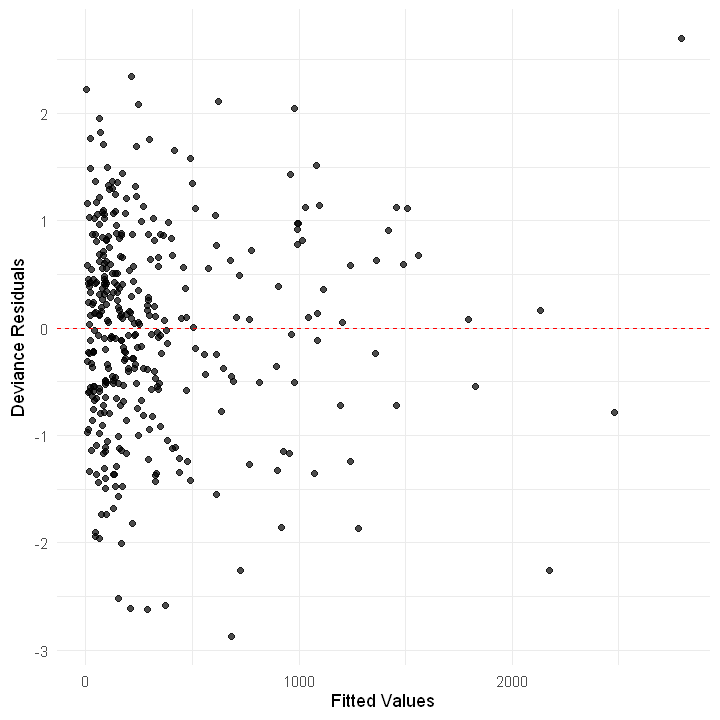

[1] 264 196

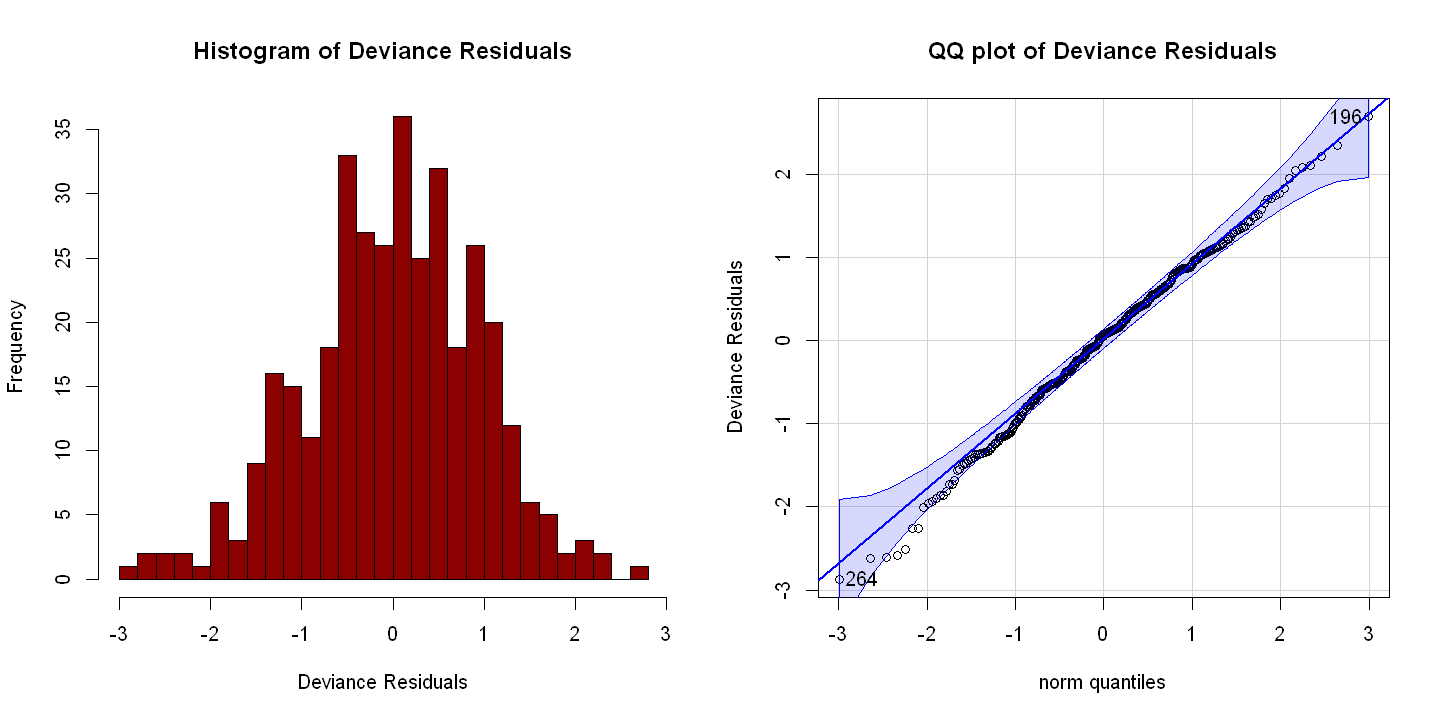

In [41]:
# Get residuals
res <- resid(pois_model_reduced4, type = "deviance")

# Constant variance check
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = fitted(pois_model_reduced4), y = res)) +
    geom_point(alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Fitted Values", y = "Deviance Residuals") +
    theme_minimal()

# Normality check
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
hist(res, breaks = 30, col = "red4", xlab = "Deviance Residuals", main = "Histogram of Deviance Residuals")
qqPlot(res, envelope = 0.95, ylab = "Deviance Residuals", main = "QQ plot of Deviance Residuals")

We're still seeing violations for constant variance and normality. From the pairs panel, there is a strong linear relationship between `avg_prior_misdemeanor` and `avg_prior_felony`. Let's create an interaction term between them.

In [42]:
pois_model_reduced5 <- glm(count_recid ~ county_name + year + Unemployment.Rate_bin + 
                           avg_prior_misdemeanor_bin + avg_age_judge + avg_prior_felony + 
                           Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score_bin +
                           avg_prior_misdemeanor*avg_prior_felony, 
                          family = "poisson", data = df_clean, offset = log(count_releases)) 

Check GOF:

In [43]:
cat("Using deviance residuals:")
with(pois_model_reduced5, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_reduced5, cbind(res.deviance = sum(resid(pois_model_reduced5, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_reduced5, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
321.727,272,0.0205468


Using pearson residuals:

res.deviance,df,pval
321.7407,272,0.02052064


Check residuals:

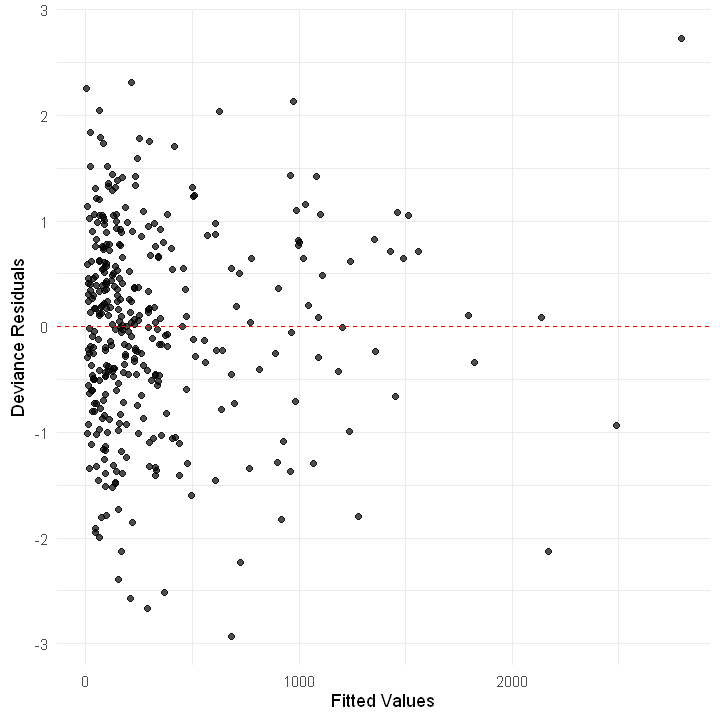

[1] 264 196

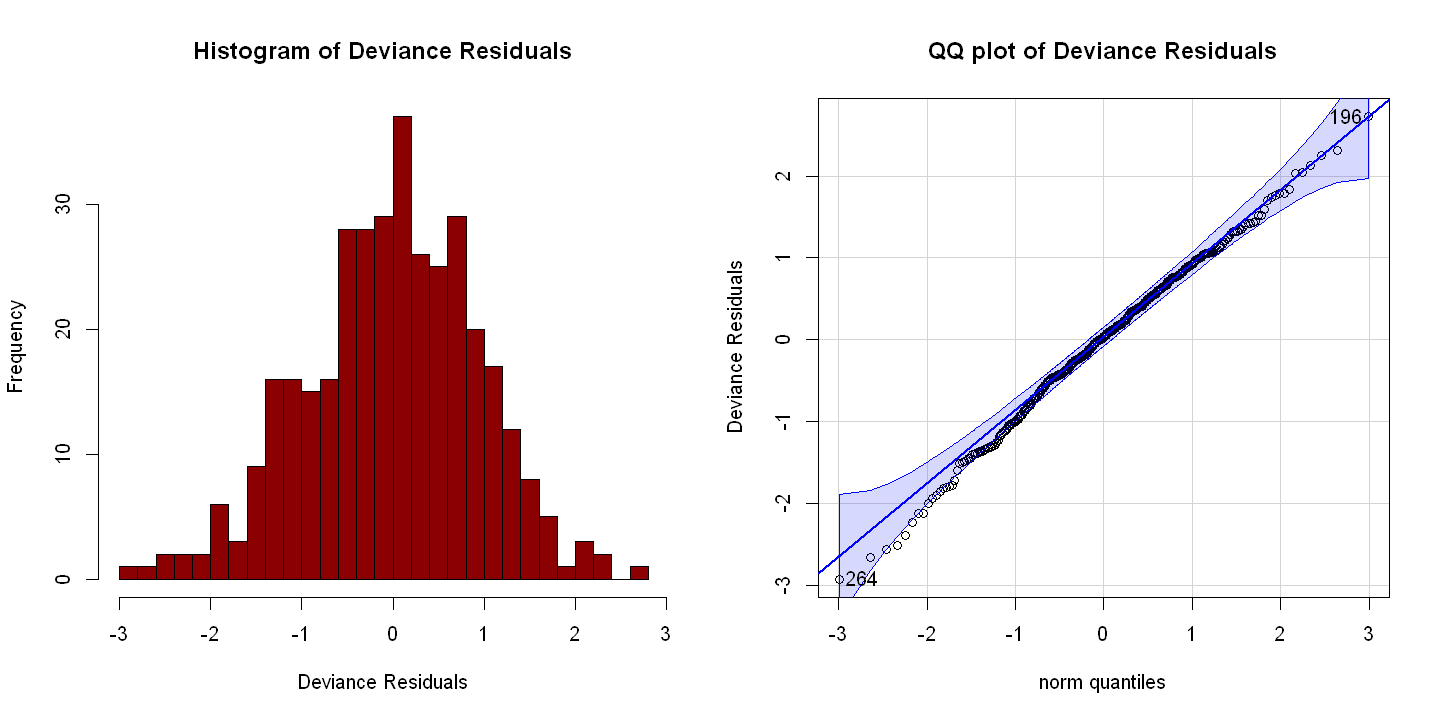

In [44]:
# Get residuals
res <- resid(pois_model_reduced5, type = "deviance")

# Constant variance check
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = fitted(pois_model_reduced5), y = res)) +
    geom_point(alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Fitted Values", y = "Deviance Residuals") +
    theme_minimal()

# Normality check
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
hist(res, breaks = 30, col = "red4", xlab = "Deviance Residuals", main = "Histogram of Deviance Residuals")
qqPlot(res, envelope = 0.95, ylab = "Deviance Residuals", main = "QQ plot of Deviance Residuals")

Still violating both assumptions. From the pairs panel, there is a quadratic relationship between `recid_rate` and `avg_prior_felony`. Therefore, let's include a quadratic term for `avg_prior_felony`. 

In [45]:
pois_model_reduced6 <- glm(count_recid ~ county_name + year + Unemployment.Rate_bin + 
                           avg_prior_misdemeanor_bin + avg_age_judge + avg_prior_felony + 
                           Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score_bin +
                           avg_prior_misdemeanor*avg_prior_felony + poly(avg_prior_felony, 2), 
                          family = "poisson", data = df_clean, offset = log(count_releases)) 

Check GOF:

In [46]:
cat("Using deviance residuals:")
with(pois_model_reduced6, cbind(res.deviance = deviance,
    df = df.residual,
    pval = pchisq(deviance, df.residual, lower.tail = FALSE)))

cat("Using pearson residuals:")
with(pois_model_reduced6, cbind(res.deviance = sum(resid(pois_model_reduced6, type = "pearson")^2),
    df = df.residual,
    pval = pchisq(sum(resid(pois_model_reduced6, type = "pearson")^2), df.residual, lower.tail = FALSE)))

Using deviance residuals:

res.deviance,df,pval
319.5851,271,0.02264019


Using pearson residuals:

res.deviance,df,pval
319.4277,271,0.02296811


Check residuals:

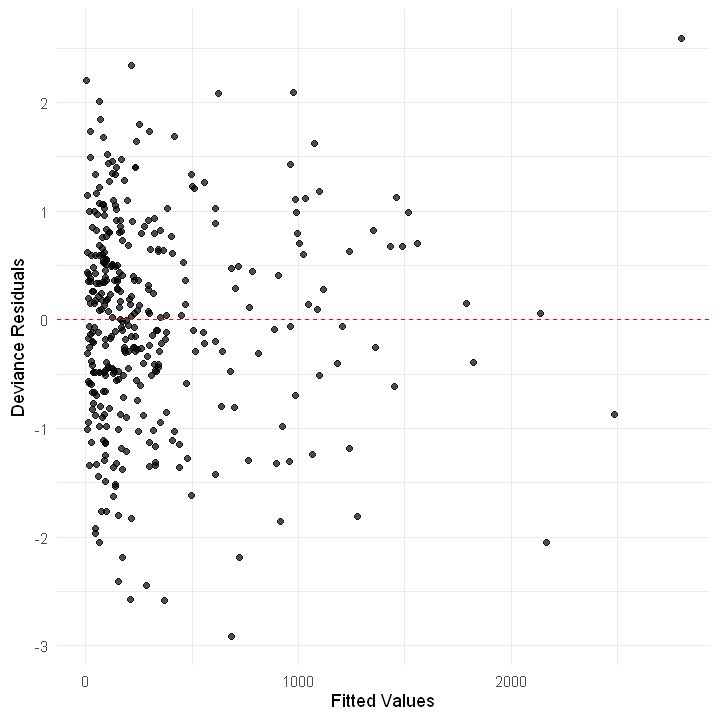

[1] 264 196

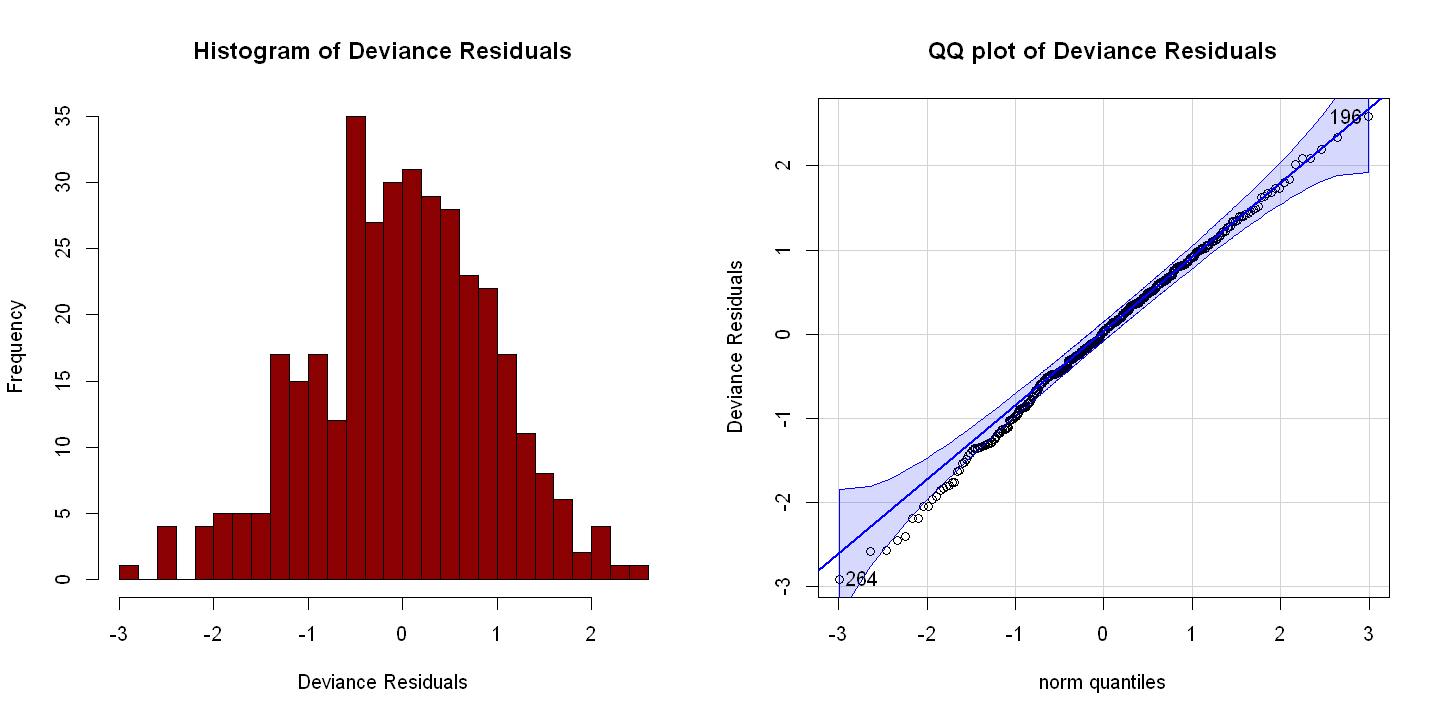

In [47]:
# Get residuals
res <- resid(pois_model_reduced6, type = "deviance")

# Constant variance check
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
ggplot(df_clean, aes(x = fitted(pois_model_reduced6), y = res)) +
    geom_point(alpha = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Fitted Values", y = "Deviance Residuals") +
    theme_minimal()

# Normality check
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
hist(res, breaks = 30, col = "red4", xlab = "Deviance Residuals", main = "Histogram of Deviance Residuals")
qqPlot(res, envelope = 0.95, ylab = "Deviance Residuals", main = "QQ plot of Deviance Residuals")

We're still seeing the same violations even after all the transformations. We therefore conclude that a non-parametric model is likely to be more appropriate for this dataset.

## Prediction

For this section, we will use the selected variables resulting from stepwise regression.

### Split the dataset

In [48]:
# For reproducibility
set.seed(2)

# Split data
train_idx <- sample(seq_len(nrow(df_clean)), size =  floor(0.8 * nrow(df_clean)))
train <- df_clean[train_idx, ]
test <- df_clean[-train_idx, ]

### Fit reduced model on train dataset

In [49]:
# Define offset
train$log_offset <- log(train$count_releases)

# Train with 5 CV
cv_model <- train(
    count_recid ~ county_name + year + Unemployment.Rate + 
                  avg_prior_misdemeanor + avg_age_judge + avg_prior_felony + 
                  Clinical_Care.Z_Score + max_hist_jail + Health_Behaviors.Z_Score +
                  offset(log_offset),
    data = train,
    method = "glm",
    family = poisson(),
    trControl = trainControl(method = "cv", number = 5))

### Predict on test dataset

In [50]:
# Define offset
test$log_offset <- log(test$count_releases)

# Predict
pred <- predict(cv_model, newdata = test, offset = test$log_offset)

### Evaluate performance

In [51]:
# Get ground truth
actual <- test$count_recid

# Calculate metrics
MSPE <- mean((actual - pred)^2)
MAE <- mean(abs(actual - pred))
MAPE <- mean(abs((actual - pred) / actual)) * 100
PM <- mean((actual - pred)^2) / sum((actual - mean(actual))^2)
r2 <- cor(actual, pred)^2

cat("Test MSE:", MSPE, "\n")
cat("Test MAE:", MAE, "\n")
cat("Test MAPE:", MAPE, "\n")
cat("Test PM:", PM, "\n")
cat("Test R-squared:", r2, "\n")

# Calculate adjusted R-squared
n <- length(actual)
p <- 9

r2_adj <- 1 - (1 - r2) * (n - 1) / (n - p - 1)
cat("Test adjusted R-squared:", r2_adj)

Test MSE: 6844.174 
Test MAE: 40.64165 
Test MAPE: 14.33036 
Test PM: 0.0006479283 
Test R-squared: 0.9572042 
Test adjusted R-squared: 0.9509919

The trained model performs very well on the test dataset.